In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,1)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, grayscale=True, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 1)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 1)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-grayscale-xception-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 123s - loss: 0.3123 - acc: 0.9097 - val_loss: 3.5219 - val_acc: 0.0275
Epoch 2/100
8394/8394 [==============================] - 121s - loss: 0.1259 - acc: 0.9579 - val_loss: 6.6190 - val_acc: 0.0688
Epoch 3/100
8394/8394 [==============================] - 123s - loss: 0.0831 - acc: 0.9725 - val_loss: 0.8054 - val_acc: 0.6910
Epoch 4/100
8394/8394 [==============================] - 121s - loss: 0.0920 - acc: 0.9690 - val_loss: 12.9716 - val_acc: 0.1291
Epoch 5/100
8394/8394 [==============================] - 122s - loss: 0.0886 - acc: 0.9705 - val_loss: 0.2625 - val_acc: 0.9524
Epoch 6/100
8394/8394 [==============================] - 122s - loss: 0.0651 - acc: 0.9778 - val_loss: 4.2421 - val_acc: 0.2423
Epoch 7/100
8394/8394 [==============================] - 122s - loss: 0.0609 - acc: 0.9808 - val_loss: 9.9408 - val_acc: 0.3175
Epoch 8/100
8394/8394 [==============================] -

8394/8394 [==============================] - 117s - loss: 1.8633e-06 - acc: 1.0000 - val_loss: 0.0842 - val_acc: 0.9884
Epoch 64/100
8394/8394 [==============================] - 118s - loss: 1.7015e-06 - acc: 1.0000 - val_loss: 0.0846 - val_acc: 0.9884
Epoch 65/100
8394/8394 [==============================] - 118s - loss: 9.1753e-07 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9894
Epoch 66/100
8394/8394 [==============================] - 118s - loss: 1.7886e-06 - acc: 1.0000 - val_loss: 0.0851 - val_acc: 0.9894
Epoch 67/100
8394/8394 [==============================] - 117s - loss: 1.3764e-06 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9905
Epoch 68/100
8394/8394 [==============================] - 117s - loss: 9.2108e-07 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9905
Epoch 69/100
8394/8394 [==============================] - 117s - loss: 0.0775 - acc: 0.9849 - val_loss: 15.9044 - val_acc: 0.0127
Epoch 70/100
8394/8394 [==============================] - 117s - loss: 0.0206 - acc: 

8397/8397 [==============================] - 117s - loss: 0.0155 - acc: 0.9950 - val_loss: 0.0911 - val_acc: 0.9745
Epoch 25/100
8397/8397 [==============================] - 118s - loss: 0.0201 - acc: 0.9933 - val_loss: 0.0431 - val_acc: 0.9894
Epoch 26/100
8397/8397 [==============================] - 118s - loss: 0.0129 - acc: 0.9958 - val_loss: 0.0485 - val_acc: 0.9873
Epoch 27/100
8397/8397 [==============================] - 117s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0296 - val_acc: 0.9894
Epoch 28/100
8397/8397 [==============================] - 117s - loss: 0.0046 - acc: 0.9986 - val_loss: 0.0291 - val_acc: 0.9904
Epoch 29/100
8397/8397 [==============================] - 117s - loss: 0.0372 - acc: 0.9892 - val_loss: 1.6607 - val_acc: 0.7123
Epoch 30/100
8397/8397 [==============================] - 117s - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0277 - val_acc: 0.9915
Epoch 31/100
8397/8397 [==============================] - 118s - loss: 0.0045 - acc: 0.9981 - val_loss: 0.0342

8397/8397 [==============================] - 118s - loss: 4.4146e-04 - acc: 0.9999 - val_loss: 0.0244 - val_acc: 0.9947
Epoch 88/100
8397/8397 [==============================] - 118s - loss: 8.5104e-05 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9936
Epoch 89/100
8397/8397 [==============================] - 118s - loss: 1.8192e-04 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9947
Epoch 90/100
8397/8397 [==============================] - 117s - loss: 6.8279e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9947
Epoch 91/100
8397/8397 [==============================] - 117s - loss: 4.9499e-05 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 0.9947
Epoch 92/100
8397/8397 [==============================] - 117s - loss: 2.5872e-05 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9947
Epoch 93/100
8397/8397 [==============================] - 117s - loss: 1.8610e-05 - acc: 1.0000 - val_loss: 0.0257 - val_acc: 0.9947
Epoch 94/100
8397/8397 [==============================] - 117s - loss: 1.4231e-05 

8401/8401 [==============================] - 117s - loss: 8.0796e-04 - acc: 0.9998 - val_loss: 0.0712 - val_acc: 0.9904
Epoch 50/100
8401/8401 [==============================] - 117s - loss: 3.8525e-04 - acc: 0.9999 - val_loss: 0.0914 - val_acc: 0.9787
Epoch 51/100
8401/8401 [==============================] - 117s - loss: 0.0036 - acc: 0.9998 - val_loss: 0.0798 - val_acc: 0.9883
Epoch 52/100
8401/8401 [==============================] - 117s - loss: 0.0023 - acc: 0.9992 - val_loss: 0.0982 - val_acc: 0.9872
Epoch 53/100
8401/8401 [==============================] - 117s - loss: 0.0317 - acc: 0.9905 - val_loss: 0.0981 - val_acc: 0.9819
Epoch 54/100
8401/8401 [==============================] - 116s - loss: 0.0097 - acc: 0.9969 - val_loss: 0.1696 - val_acc: 0.9478
Epoch 55/100
8401/8401 [==============================] - 116s - loss: 0.0024 - acc: 0.9990 - val_loss: 0.0660 - val_acc: 0.9893
Epoch 56/100
8401/8401 [==============================] - 117s - loss: 0.0136 - acc: 0.9973 - val_loss

8403/8403 [==============================] - 117s - loss: 0.1151 - acc: 0.9711 - val_loss: 0.0853 - val_acc: 0.9733
Epoch 12/100
8403/8403 [==============================] - 117s - loss: 0.0477 - acc: 0.9849 - val_loss: 0.0366 - val_acc: 0.9904
Epoch 13/100
8403/8403 [==============================] - 117s - loss: 0.0351 - acc: 0.9880 - val_loss: 0.0743 - val_acc: 0.9754
Epoch 14/100
8403/8403 [==============================] - 117s - loss: 0.0266 - acc: 0.9910 - val_loss: 0.0288 - val_acc: 0.9915
Epoch 15/100
8403/8403 [==============================] - 118s - loss: 0.0224 - acc: 0.9929 - val_loss: 2.2406 - val_acc: 0.7553
Epoch 16/100
8403/8403 [==============================] - 118s - loss: 0.0308 - acc: 0.9898 - val_loss: 1.3517 - val_acc: 0.6827
Epoch 17/100
8403/8403 [==============================] - 117s - loss: 0.0600 - acc: 0.9821 - val_loss: 0.0553 - val_acc: 0.9861
Epoch 18/100
8403/8403 [==============================] - 117s - loss: 0.0281 - acc: 0.9908 - val_loss: 0.8633

8403/8403 [==============================] - 118s - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0425 - val_acc: 0.9936
Epoch 75/100
8403/8403 [==============================] - 117s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0460 - val_acc: 0.9947
Epoch 76/100
8403/8403 [==============================] - 118s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0458 - val_acc: 0.9947
Epoch 77/100
8403/8403 [==============================] - 118s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0452 - val_acc: 0.9947
Epoch 78/100
8403/8403 [==============================] - 118s - loss: 0.0299 - acc: 0.9929 - val_loss: 4.3577 - val_acc: 0.5620
Epoch 79/100
8403/8403 [==============================] - 117s - loss: 0.0078 - acc: 0.9973 - val_loss: 0.0414 - val_acc: 0.9925
Epoch 80/100
8403/8403 [==============================] - 117s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0529 - val_acc: 0.9915
Epoch 81/100
8403/8403 [==============================] - 116s - loss: 0.0082 - acc: 0.9979 - val_loss: 0.0561

8404/8404 [==============================] - 118s - loss: 0.0147 - acc: 0.9958 - val_loss: 0.0771 - val_acc: 0.9807
Epoch 37/100
8404/8404 [==============================] - 117s - loss: 0.0581 - acc: 0.9870 - val_loss: 0.6046 - val_acc: 0.8888
Epoch 38/100
8404/8404 [==============================] - 117s - loss: 0.0350 - acc: 0.9879 - val_loss: 0.2435 - val_acc: 0.9775
Epoch 39/100
8404/8404 [==============================] - 117s - loss: 0.0046 - acc: 0.9981 - val_loss: 0.2335 - val_acc: 0.9786
Epoch 40/100
8404/8404 [==============================] - 117s - loss: 0.0068 - acc: 0.9971 - val_loss: 0.2352 - val_acc: 0.9765
Epoch 41/100
8404/8404 [==============================] - 116s - loss: 0.0040 - acc: 0.9987 - val_loss: 0.2080 - val_acc: 0.9733
Epoch 42/100
8404/8404 [==============================] - 117s - loss: 0.0026 - acc: 0.9995 - val_loss: 0.2316 - val_acc: 0.9743
Epoch 43/100
8404/8404 [==============================] - 117s - loss: 0.0042 - acc: 0.9986 - val_loss: 0.1659

8404/8404 [==============================] - 118s - loss: 5.3963e-04 - acc: 0.9998 - val_loss: 0.0498 - val_acc: 0.9914
Epoch 99/100
8404/8404 [==============================] - 117s - loss: 6.5834e-04 - acc: 0.9999 - val_loss: 0.0526 - val_acc: 0.9914
Epoch 100/100
928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.9925 (11786.4430 s)
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 117s - loss: 1.7980 - acc: 0.6610 - val_loss: 4.1001 - val_acc: 0.3144
Epoch 2/100
8404/8404 [==============================] - 117s - loss: 0.9869 - acc: 0.8122 - val_loss: 6.9948 - val_acc: 0.4021
Epoch 3/100
8404/8404 [==============================] - 117s - loss: 0.3233 - acc: 0.9064 - val_loss: 0.5625 - val_acc: 0.8856
Epoch 4/100
8404/8404 [==============================] - 116s - loss: 0.1833 - acc: 0.9429 - val_loss: 0.3398 - val_acc: 0.9059
Epoch 5/100
8404/8404 [==============================] - 117s - loss: 0.1418 - acc:

8404/8404 [==============================] - 117s - loss: 0.0090 - acc: 0.9980 - val_loss: 0.0833 - val_acc: 0.9882
Epoch 61/100
8404/8404 [==============================] - 116s - loss: 0.0065 - acc: 0.9989 - val_loss: 0.0777 - val_acc: 0.9893
Epoch 62/100
8404/8404 [==============================] - 118s - loss: 0.0026 - acc: 0.9996 - val_loss: 0.0700 - val_acc: 0.9872
Epoch 63/100
8404/8404 [==============================] - 117s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0896 - val_acc: 0.9861
Epoch 64/100
8404/8404 [==============================] - 117s - loss: 0.0124 - acc: 0.9970 - val_loss: 0.0936 - val_acc: 0.9786
Epoch 65/100
8404/8404 [==============================] - 117s - loss: 0.0079 - acc: 0.9983 - val_loss: 6.3213 - val_acc: 0.5016
Epoch 66/100
8404/8404 [==============================] - 117s - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0673 - val_acc: 0.9893
Epoch 67/100
8404/8404 [==============================] - 116s - loss: 0.0066 - acc: 0.9985 - val_loss: 0.2486

8408/8408 [==============================] - 117s - loss: 0.0658 - acc: 0.9797 - val_loss: 0.7991 - val_acc: 0.8174
Epoch 23/100
8408/8408 [==============================] - 117s - loss: 0.0488 - acc: 0.9848 - val_loss: 1.8695 - val_acc: 0.6488
Epoch 24/100
8408/8408 [==============================] - 117s - loss: 0.0412 - acc: 0.9870 - val_loss: 0.0884 - val_acc: 0.9742
Epoch 25/100
8408/8408 [==============================] - 117s - loss: 0.0527 - acc: 0.9842 - val_loss: 0.5398 - val_acc: 0.8120
Epoch 26/100
8408/8408 [==============================] - 118s - loss: 0.0475 - acc: 0.9845 - val_loss: 1.3205 - val_acc: 0.8045
Epoch 27/100
8408/8408 [==============================] - 117s - loss: 0.0414 - acc: 0.9875 - val_loss: 0.0793 - val_acc: 0.9753
Epoch 28/100
8408/8408 [==============================] - 117s - loss: 0.0419 - acc: 0.9864 - val_loss: 0.1090 - val_acc: 0.9731
Epoch 29/100
8408/8408 [==============================] - 118s - loss: 0.0399 - acc: 0.9873 - val_loss: 0.1230

8408/8408 [==============================] - 118s - loss: 0.0152 - acc: 0.9955 - val_loss: 3.8873 - val_acc: 0.5607
Epoch 86/100
8408/8408 [==============================] - 117s - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0306 - val_acc: 0.9893
Epoch 87/100
8408/8408 [==============================] - 118s - loss: 0.0013 - acc: 0.9994 - val_loss: 0.0435 - val_acc: 0.9893
Epoch 88/100
8408/8408 [==============================] - 117s - loss: 8.7230e-05 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9914
Epoch 90/100
8408/8408 [==============================] - 117s - loss: 3.6599e-05 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9903
Epoch 91/100
8408/8408 [==============================] - 118s - loss: 1.1052e-04 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9893
Epoch 92/100
8408/8408 [==============================] - 118s - loss: 2.0891e-05 - acc: 1.0000 - val_loss: 0.0470 - val_acc: 0.9903
Epoch 93/100
8408/8408 [==============================] - 117s - loss: 0.0014 - acc: 0.9995 - 

8410/8410 [==============================] - 117s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0161 - val_acc: 0.9968
Epoch 61/100
8410/8410 [==============================] - 118s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0171 - val_acc: 0.9968
Epoch 62/100
8410/8410 [==============================] - 117s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0172 - val_acc: 0.9968
Epoch 63/100
8410/8410 [==============================] - 117s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0158 - val_acc: 0.9957
Epoch 64/100
8410/8410 [==============================] - 117s - loss: 0.0347 - acc: 0.9910 - val_loss: 0.1127 - val_acc: 0.9709
Epoch 65/100
8410/8410 [==============================] - 118s - loss: 0.0100 - acc: 0.9970 - val_loss: 0.9488 - val_acc: 0.8062
Epoch 66/100
8410/8410 [==============================] - 117s - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0152 - val_acc: 0.9957
Epoch 67/100
8410/8410 [==============================] - 117s - loss: 0.0022 - acc: 0.9999 - val_loss: 0.0169

8414/8414 [==============================] - 117s - loss: 0.0417 - acc: 0.9870 - val_loss: 0.0451 - val_acc: 0.9892
Epoch 23/100
8414/8414 [==============================] - 119s - loss: 0.0468 - acc: 0.9861 - val_loss: 0.1906 - val_acc: 0.9568
Epoch 24/100
8414/8414 [==============================] - 118s - loss: 0.0327 - acc: 0.9919 - val_loss: 0.0720 - val_acc: 0.9859
Epoch 25/100
8414/8414 [==============================] - 116s - loss: 0.0165 - acc: 0.9962 - val_loss: 0.0518 - val_acc: 0.9870
Epoch 26/100
8414/8414 [==============================] - 116s - loss: 0.0151 - acc: 0.9966 - val_loss: 0.0474 - val_acc: 0.9849
Epoch 27/100
8414/8414 [==============================] - 117s - loss: 0.0189 - acc: 0.9954 - val_loss: 0.0449 - val_acc: 0.9881
Epoch 28/100
8414/8414 [==============================] - 117s - loss: 0.0173 - acc: 0.9962 - val_loss: 3.4442 - val_acc: 0.6811
Epoch 29/100
8414/8414 [==============================] - 117s - loss: 0.0235 - acc: 0.9930 - val_loss: 0.1298

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9854


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

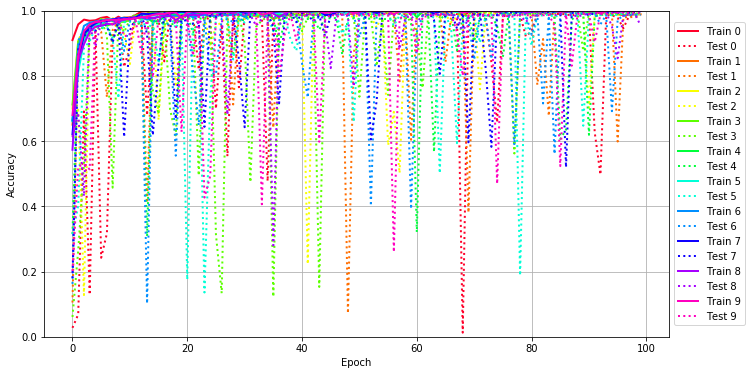

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

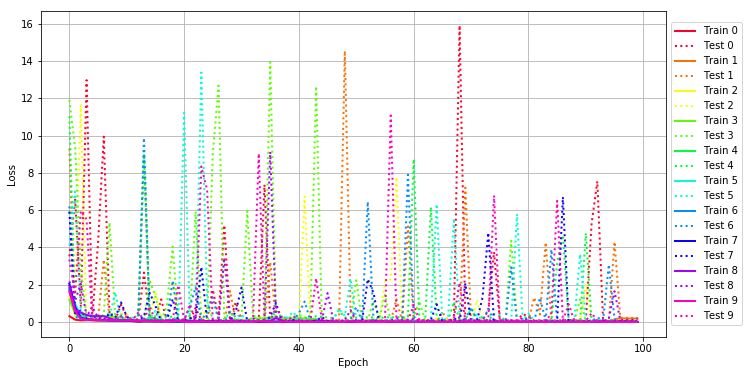

In [12]:
plot_loss(history)

Plotting the confusion matrix


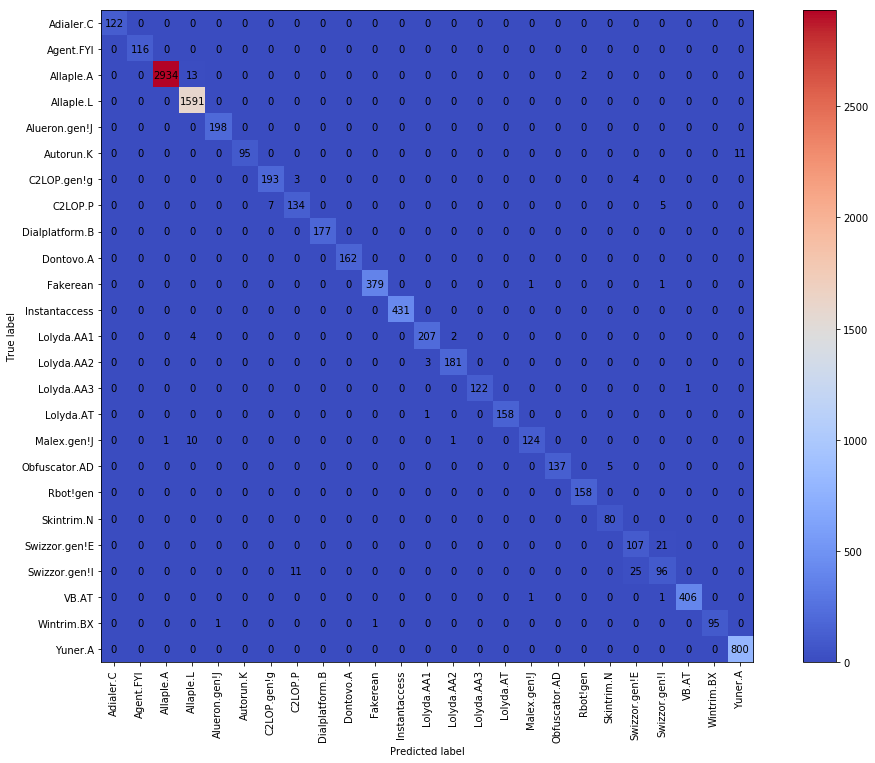

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


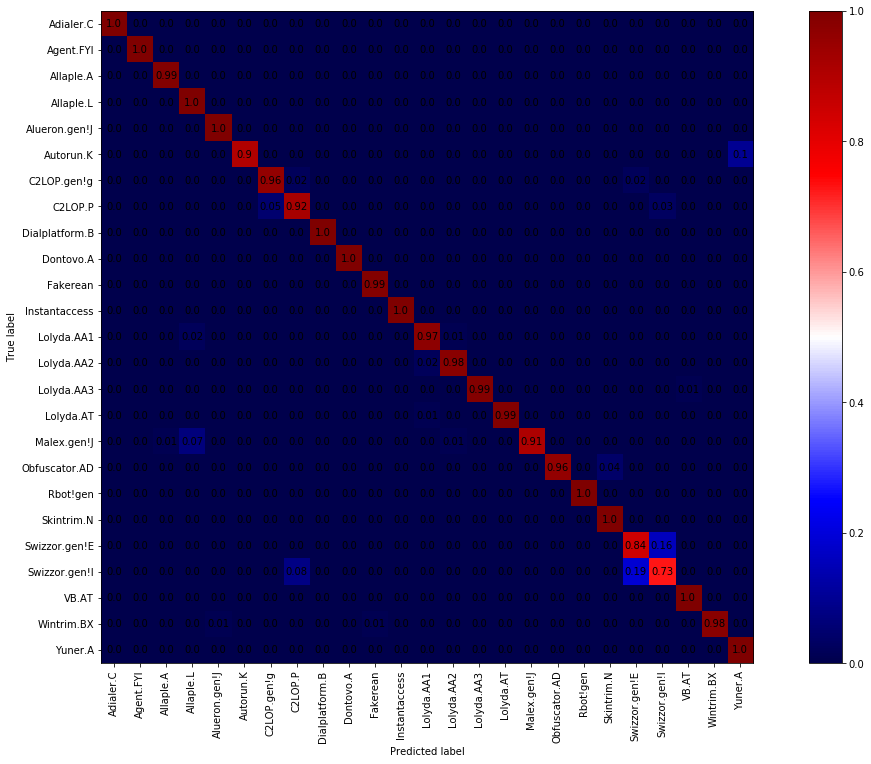

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


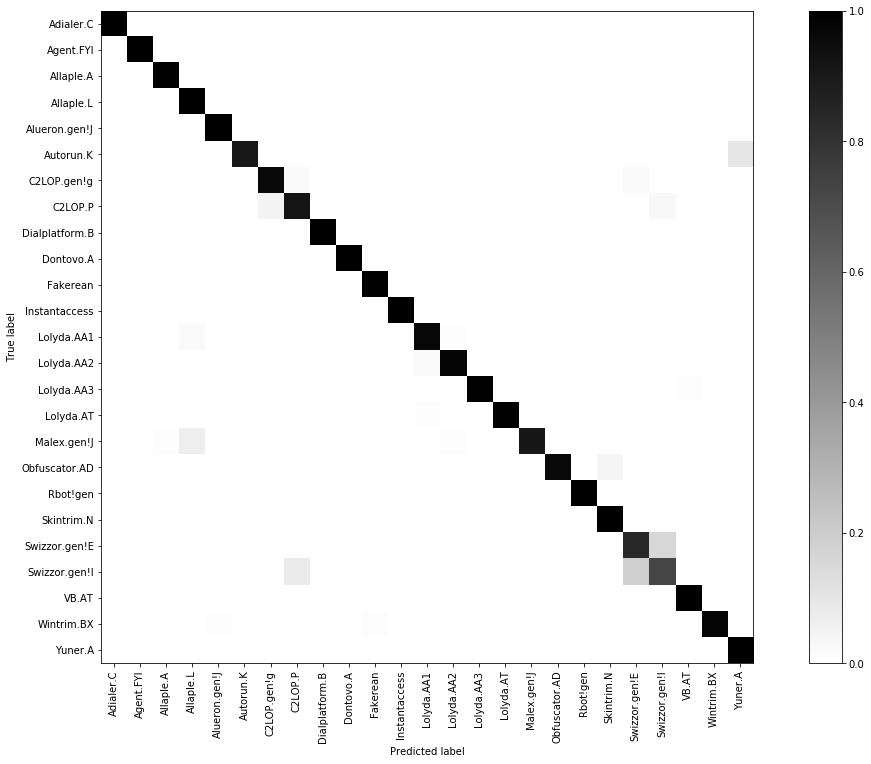

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


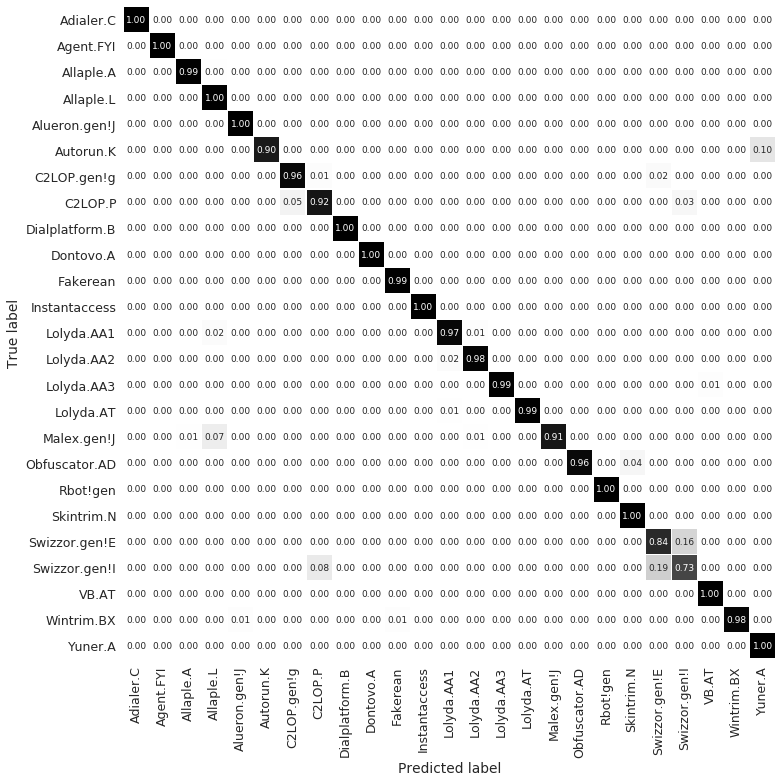

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'acc': [0.9096974029068382, 0.95794615201334288, 0.97248034310221587, 0.96902549437235896, 0.9704550869668811, 0.97784131519675732, 0.98081963304283792, 0.9704550869668811, 0.98153442935430069, 0.97164641411951502, 0.97796044793900405, 0.98665713604955918, 0.99690254944007628, 0.99773647843697877, 0.98618060519418638, 0.99571122230164399, 0.99046938289254227, 0.99773647843697877, 0.997855611150822, 0.98999285203716936, 0.99833214200619491, 0.997855611150822, 0.99821300929235168, 0.99928520371694063, 0.99821300929235168, 0.99177984274481767, 0.98987371932332624, 0.99618775315701691, 0.99714081486776274, 0.99928520371694063, 0.99988086728615677, 1.0, 1.0, 0.99964260185847031, 0.98153442935430069, 0.99678341672623305, 0.99976173457231354, 0.9991660710030974, 0.99964260185847031, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98487014534191086, 0.99440076244936859, 0.9972599

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

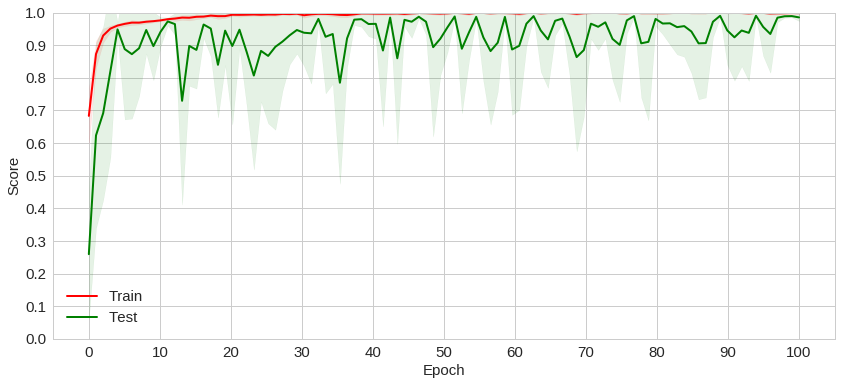

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

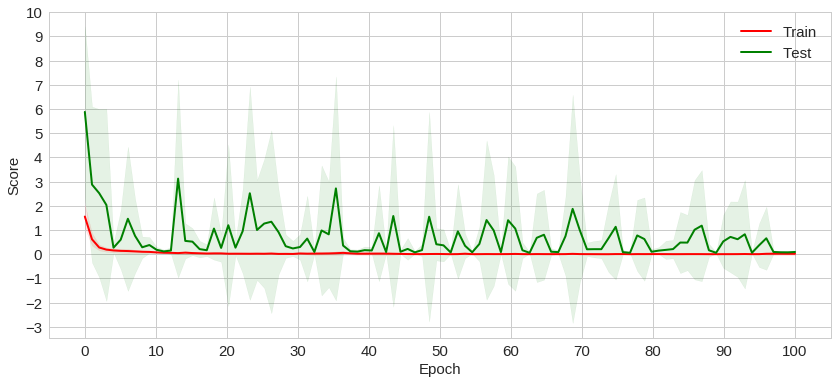

In [21]:
plot_mean_loss(history)

In [22]:
hist = [{'acc': [0.9096974029068382, 0.95794615201334288, 0.97248034310221587, 0.96902549437235896, 0.9704550869668811, 0.97784131519675732, 0.98081963304283792, 0.9704550869668811, 0.98153442935430069, 0.97164641411951502, 0.97796044793900405, 0.98665713604955918, 0.99690254944007628, 0.99773647843697877, 0.98618060519418638, 0.99571122230164399, 0.99046938289254227, 0.99773647843697877, 0.997855611150822, 0.98999285203716936, 0.99833214200619491, 0.997855611150822, 0.99821300929235168, 0.99928520371694063, 0.99821300929235168, 0.99177984274481767, 0.98987371932332624, 0.99618775315701691, 0.99714081486776274, 0.99928520371694063, 0.99988086728615677, 1.0, 1.0, 0.99964260185847031, 0.98153442935430069, 0.99678341672623305, 0.99976173457231354, 0.9991660710030974, 0.99964260185847031, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98487014534191086, 0.99440076244936859, 0.99725994758160585, 0.99928520371694063, 1.0, 0.99964260185847031, 0.99654515129854659, 0.99928520371694063, 1.0, 1.0, 1.0, 0.99809387657850845, 0.99463902787705505, 0.99690254944007628, 0.99928520371694063, 0.99833214200619491, 1.0, 1.0, 1.0, 0.99976173457231354, 0.99988086728615677, 1.0, 1.0, 0.99809387657850845, 0.99046938289254227, 0.99821300929235168, 0.99940433643078386, 0.99952346914462709, 0.99892780557541105, 0.99976173457231354, 1.0, 0.99988086728615677], 'loss': [0.31232704482803975, 0.1258548734239632, 0.083059455981056032, 0.092019314830867574, 0.088627357527942943, 0.065104684205084487, 0.060876723755242459, 0.094558884282519851, 0.057083268260438157, 0.093086911835822003, 0.066103109571535104, 0.039953641102831013, 0.0076288787126071256, 0.0069562306383594494, 0.046695531870050197, 0.014746076974957096, 0.031684636926193985, 0.0070529865001096176, 0.0057245697234659136, 0.035671083190246665, 0.0046539958223432657, 0.0069916821743219995, 0.0072603290249782489, 0.002981225771482993, 0.0038110369272878783, 0.026925788154095066, 0.12053128524744244, 0.013191700576710489, 0.0089135505401445429, 0.0027997120899057224, 0.00034082534496942006, 0.00024935464097402529, 0.00021888933875981471, 0.00093051262414977113, 0.072543782687677874, 0.01289844535565913, 0.0019892694860664333, 0.0020964326822004269, 0.0011937445139948227, 0.00055651437312263981, 0.00019699735889605935, 6.878676591156723e-05, 8.8613694602250446e-05, 3.3623975036426517e-05, 3.6885337340999891e-05, 2.0173681362957041e-05, 2.2163149749373442e-05, 1.5447255630847619e-05, 1.3063789216931645e-05, 1.253011499546848e-05, 1.2334271180303936e-05, 1.0527859740099265e-05, 8.2582767246923038e-06, 6.1031984898533918e-06, 1.2887914430561014e-05, 5.1873052611322487e-06, 4.7633089544273754e-06, 5.8878538433440829e-06, 3.2262609376222558e-06, 3.3070798684630664e-06, 3.8647747586391659e-06, 4.505508889156518e-06, 1.8633216217252648e-06, 1.7015271426099841e-06, 9.1752931825529345e-07, 1.7886310447602867e-06, 1.3764244020409622e-06, 9.2108178488463184e-07, 0.077487079848981219, 0.020562081036926326, 0.010531716649718185, 0.003136668375826805, 0.00026890524388000945, 0.00096998644466860862, 0.011167482465088195, 0.0026668796095199159, 0.00023732512756482132, 8.0640945952403377e-05, 0.00025072496560654759, 0.0074953056653357455, 0.018909594584365141, 0.0089171713222205035, 0.0021046949867792432, 0.0061755597547898692, 0.00017128618699550121, 0.00010204761536535639, 4.5213560656742829e-05, 0.00056330938035242556, 0.00044940781974333119, 5.7674433041075204e-05, 4.6828844043954527e-05, 0.0070563518941658097, 0.043191011355207844, 0.0052175744309206386, 0.0021801827567325413, 0.0011822723781957402, 0.0039728778586905445, 0.00061642126742232552, 6.0247054104313621e-05, 0.00033511266957638055], 'val_acc': [0.027513227513227514, 0.068783068783068779, 0.69100529100529096, 0.1291005291005291, 0.95238095238095233, 0.24232804232804234, 0.31746031746031744, 0.91640211640211644, 0.97566137566137567, 0.82751322751322753, 0.88677248677248677, 0.98941798941798942, 0.982010582010582, 0.67936507936507939, 0.96190476190476193, 0.97248677248677251, 0.84444444444444444, 0.98941798941798942, 0.99047619047619051, 0.97354497354497349, 0.97989417989417993, 0.98730158730158735, 0.81904761904761902, 0.97883597883597884, 0.97354497354497349, 0.69947089947089947, 0.95767195767195767, 0.5534391534391534, 0.99047619047619051, 0.76507936507936503, 0.98730158730158735, 0.99047619047619051, 0.99153439153439149, 0.98306878306878309, 0.47724867724867726, 0.97460317460317458, 0.98518518518518516, 0.98095238095238091, 0.98941798941798942, 0.99153439153439149, 0.99047619047619051, 0.99047619047619051, 0.99153439153439149, 0.99047619047619051, 0.99153439153439149, 0.99153439153439149, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.99153439153439149, 0.98835978835978833, 0.98835978835978833, 0.98941798941798942, 0.98941798941798942, 0.99047619047619051, 0.99047619047619051, 0.012698412698412698, 0.98835978835978833, 0.99047619047619051, 0.98730158730158735, 0.982010582010582, 0.84021164021164019, 0.65714285714285714, 0.982010582010582, 0.98835978835978833, 0.99047619047619051, 0.98730158730158735, 0.92063492063492058, 0.9375661375661376, 0.98941798941798942, 0.98835978835978833, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.98941798941798942, 0.98412698412698407, 0.99153439153439149, 0.99047619047619051, 0.99047619047619051, 0.62645502645502649, 0.49735449735449733, 0.98624338624338626, 0.98624338624338626, 0.97777777777777775, 0.946031746031746, 0.98412698412698407, 0.98518518518518516, 0.98518518518518516], 'val_loss': [3.5218604213976987, 6.6189607660606429, 0.80542994616996677, 12.971552462300295, 0.2624718834051078, 4.2421436022356076, 9.9408060268119538, 0.40948391127452244, 0.11177666044329594, 0.92101472386691619, 0.30276601656469693, 0.069446770815984424, 0.071414850499461252, 2.6535552962116506, 0.16282077055689043, 0.11423075139271041, 1.2121150020394351, 0.063129195814309924, 0.063765684412036144, 0.097922723601584813, 0.1371727214072464, 0.069388503635849863, 0.75245663223096027, 0.10001859075242156, 0.14306604733146694, 1.7293985262165799, 0.2049818086646473, 5.1953328357613149, 0.04882885795702336, 1.0605501435515949, 0.07450261559794262, 0.07049243953518057, 0.058174431605184318, 0.11087705314709072, 7.3648938467909213, 0.10600115588932428, 0.077664176239392521, 0.089904224018991036, 0.082021685222902929, 0.070766389554979173, 0.076691449800809247, 0.073670604263554845, 0.073821862121118867, 0.077222627781425204, 0.072924592185724821, 0.073764431166345387, 0.077661241290104099, 0.078271627146162426, 0.077677414727832406, 0.076361313904958275, 0.078053170889683249, 0.080032319574073502, 0.079657855633841673, 0.080606271916232056, 0.075386134878264371, 0.078570513468122022, 0.081634675168648071, 0.083175582173461424, 0.083333918917384023, 0.079923209518897281, 0.081030638420443418, 0.083576953502232473, 0.084240394202513114, 0.084619738344643966, 0.08467046013198011, 0.08511438644110185, 0.083983072373056883, 0.085965314699892381, 15.904430627570582, 0.07153997146975434, 0.064862992836312028, 0.073751109121162561, 0.10447161331912776, 0.62882852878763362, 3.7512074474144925, 0.079498184535604532, 0.078806455629159347, 0.070622976614877486, 0.0837495951244797, 0.41600022002128551, 0.30797016027826279, 0.070076596459183182, 0.091695317606419566, 0.076702368477546745, 0.076595315561755306, 0.084541221923679868, 0.082776506237354608, 0.10861741329339322, 0.088786131609783436, 0.080571540390419347, 0.087055055954560798, 5.2743580382337054, 7.5447767051073029, 0.092223001485828932, 0.089564230833685615, 0.12834293643038769, 0.21882390842573765, 0.10086290524989099, 0.096606090397221206, 0.10681387954881874]},
{'acc': [0.65047040619679231, 0.87733714433174637, 0.92140050027801179, 0.94378944861259972, 0.96248660245736151, 0.96951292128140998, 0.97534833879176674, 0.96975110158389899, 0.97475288793616766, 0.97892104332910146, 0.97963558413719187, 0.97868286292723594, 0.9757056092455002, 0.98023103489341434, 0.98773371442181734, 0.99380731213528639, 0.99297368107657502, 0.99285459092533046, 0.99345004168155293, 0.99297368107657502, 0.9969036560676432, 0.99487912349648688, 0.99416458258901985, 0.99499821364773133, 0.99333095153030848, 0.99583184470644281, 0.99964272954626654, 0.99857091829863931, 0.98916279623675119, 0.99571275455519825, 0.99809455758008814, 0.99738001667262122, 0.9984518280338216, 0.99773728712635468, 0.99964272954626654, 0.99476003334524232, 0.99654638561390974, 0.9969036560676432, 0.99785637727759913, 0.99940454924377753, 0.99988090984875555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99011551744670712, 0.99083005835417415, 0.99904727879004407, 0.99904727879004407, 0.99916636904066514, 0.99464094319399787, 0.99857091818506605, 0.99857091818506605, 0.99773728712635468, 0.99940454924377753, 0.99809455758008814, 0.99869000833631061, 0.99749910682386567, 0.99976181969751099, 0.99964272954626654, 0.99976181969751099, 0.99964272954626654, 0.99416458258901985, 0.99738001667262122, 0.99749910682386567, 0.99869000833631061, 0.99809455758008814, 0.99952363939502198, 1.0, 1.0, 1.0, 0.99595093485768726, 0.99880909848755506, 0.99964272954626654, 0.99988090984875555, 1.0, 1.0, 0.99964272954626654, 0.99630820531142072, 0.99678456591639875, 0.99749910682386567, 0.99880909848755506, 0.99988090984875555, 0.99988090984875555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98844825542866088, 0.98582827200190548, 0.98749553411932833, 0.98868643563177327, 0.98868643573114978], 'loss': [1.8234831398798623, 0.74271344009915941, 0.38727212148655649, 0.19598145305407647, 0.11966029318053764, 0.099445157164322479, 0.077647241166734798, 0.09806852729748626, 0.078934082431445646, 0.06440011460173907, 0.061556257193956229, 0.065628429865683069, 0.074304694593985532, 0.059353390052136912, 0.035966105934882857, 0.019998119036850941, 0.019703541022447403, 0.02222629075184375, 0.018848906863343055, 0.020255551360161238, 0.0090295163260960716, 0.014495556345059784, 0.018188589307098612, 0.015485383269215511, 0.02009018969724442, 0.01285548516263102, 0.0017069425031581347, 0.0045758137614921746, 0.037179259662156509, 0.013826688436078333, 0.0045356295794852343, 0.0063781384702337818, 0.0050600254752338975, 0.0051949483403619014, 0.0025150763183416965, 0.019789574014813911, 0.012978143249509029, 0.010522840666973817, 0.0079862734952963581, 0.0026626658958702372, 0.00060289515751460292, 0.00016658890433033163, 0.00022597655941814637, 0.00024850523751894342, 0.0001032104305146559, 6.1798803558781574e-05, 6.9016078396479065e-05, 3.0087983322547406e-05, 0.03526162429471149, 0.034518822527105565, 0.0039900358259847635, 0.0034077177758878451, 0.0020536056613377177, 0.017659598528935373, 0.0032138969951208689, 0.0028781039712723871, 0.0060858086640616189, 0.0014158335187245742, 0.0080429769760010043, 0.0040668716944052613, 0.010187090522605757, 0.001034171802725143, 0.00090791718978160086, 0.00077153912345363708, 0.00087408447543786726, 0.018704812477933888, 0.010511114715190931, 0.0062359427485299442, 0.0042428630357990152, 0.0045562506329117477, 0.0011813764518892314, 0.00018531841288714393, 8.9315187302529397e-05, 0.00014338746824541448, 0.018026748040026901, 0.0035616305706853957, 0.0011801897097678945, 0.00045083497981263207, 8.3839265795222469e-05, 5.048565081295259e-05, 0.0020518498596014531, 0.012968221349676222, 0.011114474529142977, 0.011168542839996189, 0.002688002016001805, 0.0007370554790948542, 0.00044145558410725567, 8.5104336760423587e-05, 0.00018191611711077283, 6.8279033842343534e-05, 4.9499443764864145e-05, 2.5872326198057846e-05, 1.8610294832872356e-05, 1.4231179313149598e-05, 9.9947798747375394e-05, 0.13858588306271596, 0.19404384547887471, 0.18626343335671486, 0.18281240640018664, 0.18215328985704579], 'val_acc': [0.10509554140127389, 0.9140127388535032, 0.9288747346072187, 0.92781316348195331, 0.95647558386411891, 0.93524416135881105, 0.73460721868365175, 0.94055201698513802, 0.96709129511677283, 0.97027600849256901, 0.96921443736730362, 0.9575371549893843, 0.96284501061571126, 0.41082802547770703, 0.98832271762208068, 0.98195329087048833, 0.98195329087048833, 0.98938428874734607, 0.96390658174097665, 0.99044585987261147, 0.99150743099787686, 0.98089171974522293, 0.98726114649681529, 0.97452229299363058, 0.98938428874734607, 0.98726114649681529, 0.98938428874734607, 0.99044585987261147, 0.71231422505307851, 0.99150743099787686, 0.99363057324840764, 0.98832271762208068, 0.98089171974522293, 0.98195329087048833, 0.98938428874734607, 0.64118895966029721, 0.9861995753715499, 0.98301486199575372, 0.99044585987261147, 0.99044585987261147, 0.99256900212314225, 0.99256900212314225, 0.98726114649681529, 0.99363057324840764, 0.99363057324840764, 0.99256900212314225, 0.99256900212314225, 0.99256900212314225, 0.072186836518046707, 0.86730360934182593, 0.9861995753715499, 0.99044585987261147, 0.99044585987261147, 0.9851380042462845, 0.98832271762208068, 0.99363057324840764, 0.98832271762208068, 0.78343949044585992, 0.99363057324840764, 0.60403397027600847, 0.99256900212314225, 0.99363057324840764, 0.99256900212314225, 0.99469214437367304, 0.99469214437367304, 0.8428874734607219, 0.9861995753715499, 0.98938428874734607, 0.99044585987261147, 0.38110403397027603, 0.99363057324840764, 0.99150743099787686, 0.99363057324840764, 0.99044585987261147, 0.99256900212314225, 0.99044585987261147, 0.98726114649681529, 0.99256900212314225, 0.99363057324840764, 0.99256900212314225, 0.98407643312101911, 0.772823779193206, 0.91295116772823781, 0.67728237791932056, 0.99256900212314225, 0.99150743099787686, 0.99469214437367304, 0.99363057324840764, 0.99469214437367304, 0.99469214437367304, 0.99469214437367304, 0.99469214437367304, 0.99469214437367304, 0.99469214437367304, 0.99363057324840764, 0.59872611464968151, 0.97983014861995754, 0.97983014861995754, 0.98089171974522293, 0.98301486199575372], 'val_loss': [9.3006637253325959, 0.6324432191187852, 0.26546317407457976, 0.24603460422240497, 0.18830065776429863, 0.1622509550599944, 3.3397177451346414, 0.15353817407055628, 0.087543730665752578, 0.089040624097717777, 0.079982270111361733, 0.11314103756261339, 0.16421470421686721, 8.8888633590341914, 0.038080635052683803, 0.063464547148632061, 0.051475477752485482, 0.027329150660875469, 0.13166088978188509, 0.050381511174201705, 0.028957639102985044, 0.050963598610817222, 0.059734010039200994, 0.091132827313416626, 0.043060175147393097, 0.048477929725283024, 0.029629116391499875, 0.029096301815560149, 1.6606529438849256, 0.027711694714721881, 0.034180349362704129, 0.030981595879228351, 0.055907795257597204, 0.054386411127737386, 0.035081926394233992, 3.2161367292502261, 0.072897812989730623, 0.064737958423366104, 0.027533713454374598, 0.031605070091484271, 0.027776407970081029, 0.029609238654450733, 0.040195567694132149, 0.031633918517002105, 0.031868297317135114, 0.033889584058572363, 0.033676585516266684, 0.033325763584258088, 14.536644694658348, 0.57312047862680315, 0.028485035086450113, 0.025402499092496155, 0.025530759813079177, 0.048500860829979078, 0.040437667079922315, 0.031448144945150802, 0.036474130826491577, 1.219704448189131, 0.030807359715417447, 5.1252992495127234, 0.019494058028434794, 0.020290071818464251, 0.020594046095606045, 0.027977363469772885, 0.020706903833805149, 0.5283262100147742, 0.046032966244040942, 0.033566655276415641, 0.041597332778769716, 7.2088752010967703, 0.024558038392789038, 0.022805637743088913, 0.021676205308610218, 0.036875242330738835, 0.028447820120045608, 0.029586263700956673, 0.049413625690437321, 0.025557528901176726, 0.029786218159085526, 0.028006146125691841, 0.081717795434795931, 1.3138157343911476, 0.40355826753494267, 4.266323298034945, 0.024838048752245837, 0.023205932769660206, 0.024412288268563034, 0.025900380943299661, 0.024545468709811679, 0.025544497205154334, 0.026306339965160748, 0.025676098366991494, 0.025747933760840863, 0.026569995552684723, 0.029571536627298903, 4.2983867737075103, 0.22956485696001327, 0.22502328917574257, 0.2214719851696425, 0.22165866722548799]},
{'acc': [0.69967860968932272, 0.9084632781811689, 0.93774550650860777, 0.94822044996062482, 0.96321866445889881, 0.96655160099988091, 0.97202713962623499, 0.97405070837672703, 0.97428877514581602, 0.97631234376859899, 0.97714557790739198, 0.98381145101773604, 0.97178907272943693, 0.98869182240209497, 0.994405427925247, 0.99166765861206996, 0.99488156171884301, 0.996548029996429, 0.97881204618497797, 0.98678728722771103, 0.99369122723485304, 0.997857397928818, 0.99750029758362102, 0.99678609689322695, 0.99000119033448397, 0.99035829067968095, 0.99595286275443395, 0.99738126413522199, 0.997857397928818, 0.99595286288214302, 0.98154981549815501, 0.98571598619211998, 0.99321509344125702, 0.99750029758362102, 0.99666706344482803, 0.99738126414231698, 0.99511962861564096, 0.99880966551601003, 0.99869063206761099, 0.99964289965480302, 0.99904773241280798, 0.99464349482204495, 0.99166765861206996, 0.99761933103202005, 0.99916676586120701, 0.99904773241280798, 0.99928579930960604, 0.99845256517081304, 0.99976193310320205, 0.99988096655160097, 0.99976193310320205, 0.99916676586120701, 0.99047732412807998, 0.99690513034162598, 0.99904773241280798, 0.99726223068682296, 0.99750029758362102, 0.99369122723485304, 0.99869063206761099, 0.99964289965480302, 0.99904773241280798, 0.99976193310320205, 1.0, 1.0, 0.99833353185012308, 0.99869063206761099, 0.99857159861921196, 0.99547672896083794, 0.99904773241280798, 0.99988096655160097, 0.99880966551601003, 0.99928579930960604, 0.99976193310320205, 1.0, 0.99904773241280798, 0.99464349482204495, 0.99940483275800496, 0.99964289965480302, 1.0, 1.0, 0.99726223069391795, 0.99892869896440895, 0.99988096655160097, 1.0, 0.99904773241280798, 0.99821449827401498, 0.99892869896440895, 0.99952386620640399, 0.99892869896440895, 0.99976193310320205, 0.99880966551601003, 0.99857159861921196, 0.99821449840172405, 0.99750029758362102, 0.99928579930960604, 0.99928579930960604, 0.99976193310320205, 1.0, 1.0, 1.0], 'loss': [1.3889521438246639, 0.3147690061104218, 0.20600801284164777, 0.15533060865442805, 0.11147969534937477, 0.099827453365476063, 0.08265150684910777, 0.082440208022423606, 0.078690186351335498, 0.071498374100705794, 0.066131489126792398, 0.050748680712145902, 0.08978358693072791, 0.034304337564557828, 0.017839645271735156, 0.022185346704776128, 0.013430461975524666, 0.011616062027051189, 0.072250095842207276, 0.043212513322325306, 0.018267115528363041, 0.0062740564518158071, 0.009182507725854442, 0.0093697575003264793, 0.031428063076563512, 0.035722268675295987, 0.01118044513296707, 0.0083821002830303613, 0.0059033101307850774, 0.014071467151052659, 0.063069825617230901, 0.046695020786978111, 0.0200689236139002, 0.0066217971199908311, 0.011788008394511433, 0.0073393480082125885, 0.014356831229779869, 0.0033651367625321111, 0.0036485893680692273, 0.00096648517438928069, 0.0026975734671043092, 0.017702012642342578, 0.0283344867728554, 0.0064675470181163762, 0.0024548851883663459, 0.0028897863552426253, 0.0031061983161099326, 0.0044216549108200241, 0.00080795810129495973, 0.00038525385793702996, 0.0035776955834058281, 0.0022886108609064368, 0.03165021176339522, 0.0097235607020760787, 0.0023865492956809268, 0.013640570698931006, 0.0077244514543625209, 0.023282185563095539, 0.0046152413635832902, 0.0012698348627234477, 0.0021458100426529464, 0.00071811779163865274, 0.00030371906015283658, 7.5734723078848306e-05, 0.0057444773992899288, 0.0039946009117372058, 0.0048929883788324828, 0.017443035572633537, 0.002454071364591207, 0.00063100107589043972, 0.0031297421358248965, 0.0022703754926129928, 0.00072843641525806172, 0.00022553848068168373, 0.0027270427282961524, 0.017263461061527777, 0.0028885190820154474, 0.0014644329751701468, 0.00013880570952453918, 0.00014298164085962866, 0.008103580513063962, 0.0036102528172981484, 0.00046308458890213062, 0.0001096966757970712, 0.0034620744032829152, 0.008657394695477107, 0.0034545161824424586, 0.0022211466821872861, 0.0042552840902167098, 0.00054716228324843319, 0.0026974952136110983, 0.0040865262092320267, 0.0041463216835205922, 0.0099044607915276302, 0.0023631839432492149, 0.0015674842340287281, 0.0012032981512074741, 6.5575998669653655e-05, 3.9975543718177675e-05, 4.3553192913766079e-05], 'val_acc': [0.61620469083155649, 0.69616204690831551, 0.1279317697228145, 0.96162046908315568, 0.96055437100213215, 0.97441364605543712, 0.96908315565031988, 0.97654584221748397, 0.97441364605543712, 0.9285714285714286, 0.83582089552238803, 0.97974413646055436, 0.98827292110874199, 0.98081023454157779, 0.98827292110874199, 0.6652452025586354, 0.94882729211087424, 0.9925373134328358, 0.76652452025586348, 0.97974413646055436, 0.98720682302771856, 0.98614072494669514, 0.98720682302771856, 0.98933901918976541, 0.89125799573560771, 0.95309168443496806, 0.96375266524520253, 0.98933901918976541, 0.98720682302771856, 0.97121535181236673, 0.97441364605543712, 0.97974413646055436, 0.99040511727078895, 0.99147121535181237, 0.99147121535181237, 0.9925373134328358, 0.98933901918976541, 0.98614072494669514, 0.9925373134328358, 0.98827292110874199, 0.98827292110874199, 0.22281449893390193, 0.98827292110874199, 0.98720682302771856, 0.99040511727078895, 0.99040511727078895, 0.98720682302771856, 0.99040511727078895, 0.99040511727078895, 0.97867803837953093, 0.98827292110874199, 0.98720682302771856, 0.98187633262260132, 0.94776119402985071, 0.98933901918976541, 0.58742004264392322, 0.68976545842217485, 0.50213219616204696, 0.98933901918976541, 0.99147121535181237, 0.99147121535181237, 0.98827292110874199, 0.9925373134328358, 0.9925373134328358, 0.97228144989339016, 0.98720682302771856, 0.96481876332622596, 0.98081023454157779, 0.99040511727078895, 0.99147121535181237, 0.98827292110874199, 0.75906183368869939, 0.99147121535181237, 0.99147121535181237, 0.99147121535181237, 0.99147121535181237, 0.99040511727078895, 0.99147121535181237, 0.9925373134328358, 0.9925373134328358, 0.98081023454157779, 0.98614072494669514, 0.9925373134328358, 0.99147121535181237, 0.98400852878464817, 0.98614072494669514, 0.98933901918976541, 0.99147121535181237, 0.99147121535181237, 0.98933901918976541, 0.70255863539445629, 0.98827292110874199, 0.98933901918976541, 0.99147121535181237, 0.98933901918976541, 0.98614072494669514, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541], 'val_loss': [1.2940956790294094, 1.3224484272189994, 11.634229190313993, 0.10535330870723687, 0.10227660696485577, 0.088031434719185175, 0.095482958384344216, 0.092495436309020934, 0.079371977981564937, 0.42356553935223346, 0.42202041294457188, 0.095657454283874746, 0.067883539007863272, 0.063883085945598148, 0.057193180500166189, 1.6538861793880937, 0.19179197323984151, 0.045400536335231612, 2.1853380782996576, 0.073224918020280777, 0.059897943354538595, 0.073640869891210395, 0.083275563831086585, 0.064348411969207486, 0.86238721006732555, 0.14540564936188957, 0.14039822498200286, 0.06412962897299597, 0.082288470095920219, 0.1045267287475332, 0.10681605818283123, 0.083369013480059442, 0.063436919274527159, 0.050328054471720923, 0.06736005363108756, 0.05278427452174831, 0.06710805591024363, 0.094945103943006579, 0.052418967340462717, 0.062303996240172521, 0.071997879678881077, 6.7375534856751527, 0.065106740367672153, 0.087243058940565055, 0.065129108932777652, 0.058351428494768653, 0.090675870947454704, 0.062522606060320118, 0.071172488931735181, 0.091399860953519901, 0.0797835628281372, 0.098211183582939898, 0.098133991637293236, 0.1696007710013942, 0.066035208955959449, 2.1764715388169025, 2.2935928751959835, 7.7626379627917155, 0.061314657140229017, 0.05745637408359628, 0.059383607090206368, 0.072792735895521335, 0.069176514193306962, 0.075656041033375268, 0.17965535252256534, 0.081762907246210687, 0.19243542414587991, 0.10668992807008261, 0.05860596817876134, 0.051208026996966201, 0.07034349959541257, 1.1701229796471453, 0.06304863956633168, 0.065605583540627191, 0.064858404897976368, 0.069563909744173494, 0.076348308612474589, 0.066911298658923979, 0.074866827339641007, 0.067443285183767313, 0.1485047789073787, 0.083762354019199847, 0.069112437333065393, 0.072893581201044694, 0.089968456783273101, 0.1269801737336331, 0.062375522108026264, 0.08976156715009681, 0.068188153743154761, 0.076584617072608288, 1.9726733683222211, 0.088086031643395082, 0.075513867479372332, 0.082722032137145421, 0.077362092688067249, 0.11386860625585364, 0.091494397982326517, 0.091711928590376648, 0.090625326643360288, 0.092007337648049276]},
{'acc': [0.71224562657612867, 0.90479590632327322, 0.93407116506009757, 0.95049387133576879, 0.95620611686302515, 0.96120433178626685, 0.9540640247530644, 0.95977627047893188, 0.96560752112340831, 0.96548851600618824, 0.97108175651553019, 0.98488635016270765, 0.98798048316077591, 0.99095561114092978, 0.99285969296679755, 0.98976555996872928, 0.98214923246664676, 0.99083660597405687, 0.99476377484231826, 0.99583482089729858, 0.99666785671783886, 0.99571581578007851, 0.99404974413899794, 0.99607283113173861, 0.9969058669522789, 0.99761989765559922, 0.98809948827799599, 0.99595382601451865, 0.99952397953111982, 0.99940497441389975, 0.9969058669522789, 0.98536237058193499, 0.98369629894085442, 0.98762346780911581, 0.98786147804355584, 0.97369986909437101, 0.98143520171367371, 0.9872664524574557, 0.98821849339521595, 0.98845650367930893, 0.98512436034749495, 0.98809948827799599, 0.98857550874687616, 0.98643341663691542, 0.99083660597405687, 0.99916696417945972, 0.99833392835891943, 0.99964298464833989, 0.99988099488277993, 0.99952397953111982, 0.99988099488277993, 0.99988099488277993, 0.99880994882779961, 0.98679043198857552, 0.9984529334761395, 0.99642984648339883, 0.99773890277281918, 0.99988099488277993, 0.99988099488277993, 0.99726288230393911, 0.99821492324169936, 0.99666785671783886, 0.99940497441389975, 0.99619183624895868, 0.9969058669522789, 0.99928596929667979, 0.99940497441389975, 0.99940497441389975, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99750089253837915, 0.99785790789003925, 0.99964298464833989, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99285969296679755, 0.99726288230393911, 0.99916696417945972, 0.99785790789003925, 0.99880994882779961, 0.99964298464833989, 0.99988099488277993, 0.99976198976555997, 0.99988099488277993, 0.99916696417945972, 0.99988099488277993, 0.99988099488277993, 0.99404974413899794, 0.99654885160061879, 0.99869094371057954, 0.99940497441389975, 0.99988099488277993, 0.99916696417945972, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99928596929667979], 'loss': [1.1860156166337863, 0.49047991987723444, 0.3759649264438123, 0.32563804687541342, 0.31415592270145087, 0.2727709066402178, 0.32713372374976885, 0.27812954036054099, 0.25623185979473928, 0.2506581861543784, 0.11507310035106406, 0.047669865211930097, 0.035080790021911744, 0.026561041076248772, 0.022400733089970239, 0.030837292554966731, 0.060011754934607829, 0.028111163900582593, 0.016232004299399715, 0.012180236055156942, 0.012899829585621215, 0.013372963101282619, 0.019279869193713599, 0.013086727252491751, 0.0095719755136297741, 0.008637385046602053, 0.040914273488092422, 0.013513719048005945, 0.0037256882977498539, 0.0044029550374193984, 0.010417296577657066, 0.11484469487611866, 0.20020136955936219, 0.18790687321713537, 0.18620211180553012, 0.26329457084240482, 0.20931452889885932, 0.18805488474473928, 0.18689344184470255, 0.1849954771080477, 0.19407544340224986, 0.18607111134400198, 0.18459377107083591, 0.15377843870219435, 0.030964101727238225, 0.0045241367118665863, 0.0062212392603537402, 0.0037593835407931436, 0.0022791453233841998, 0.0030894387091110007, 0.0023089477844510584, 0.002141561605633926, 0.0056092522591738485, 0.12909832395781731, 0.0067540080352439602, 0.011757509198787239, 0.0064643456041775255, 0.0021976698575767134, 0.0021107697468708414, 0.011744686171934662, 0.0092304110809432408, 0.013185276810727316, 0.0036028727320716728, 0.012423471135817212, 0.018779405651171085, 0.0033094310002480189, 0.0031726040241077643, 0.0033330604863268457, 0.0021484580842948148, 0.001974762758064485, 0.0021030549750863949, 0.010636090697278913, 0.0076996296332970757, 0.0029821613958711172, 0.0020804043506520175, 0.0019729822523904877, 0.0019581680811459161, 0.029941603818144116, 0.0078084032808434789, 0.0041272453896400597, 0.0082289963167256914, 0.0054991517646468483, 0.0025120410014438455, 0.0021468391541401306, 0.0022978614986593278, 0.0020506033331216095, 0.0035670167459465035, 0.0021172192624482468, 0.0020576568248337618, 0.020580021775631549, 0.013537307141697964, 0.0047039212243413248, 0.0039061714047347695, 0.002181639112096222, 0.0040560372086066842, 0.0022998472636383974, 0.002164273455308939, 0.0019915619208244815, 0.0019661998858966499, 0.003339297767594381], 'val_acc': [0.060897435897435896, 0.26495726495726496, 0.52991452991452992, 0.95833333333333337, 0.95192307692307687, 0.9754273504273504, 0.92200854700854706, 0.45726495726495725, 0.97115384615384615, 0.93376068376068377, 0.97329059829059827, 0.99038461538461542, 0.9754273504273504, 0.99145299145299148, 0.75534188034188032, 0.68269230769230771, 0.98611111111111116, 0.69764957264957261, 0.61752136752136755, 0.99038461538461542, 0.97435897435897434, 0.97970085470085466, 0.49465811965811968, 0.98290598290598286, 0.9850427350427351, 0.31303418803418803, 0.13354700854700854, 0.9786324786324786, 0.86111111111111116, 0.99145299145299148, 0.90170940170940173, 0.47435897435897434, 0.95085470085470081, 0.97008547008547008, 0.98076923076923073, 0.12286324786324786, 0.96901709401709402, 0.98076923076923073, 0.98183760683760679, 0.98076923076923073, 0.93696581196581197, 0.97970085470085466, 0.97970085470085466, 0.15277777777777779, 0.99145299145299148, 0.99465811965811968, 0.9850427350427351, 0.99145299145299148, 0.99465811965811968, 0.99145299145299148, 0.73611111111111116, 0.99145299145299148, 0.98397435897435892, 0.83012820512820518, 0.97649572649572647, 0.74145299145299148, 0.98824786324786329, 0.99252136752136755, 0.99572649572649574, 0.95940170940170943, 0.9358974358974359, 0.76282051282051277, 0.99145299145299148, 0.99465811965811968, 0.97970085470085466, 0.99038461538461542, 0.98611111111111116, 0.98931623931623935, 0.99252136752136755, 0.99252136752136755, 0.99038461538461542, 0.99252136752136755, 0.99465811965811968, 0.99358974358974361, 0.99465811965811968, 0.99465811965811968, 0.99465811965811968, 0.56196581196581197, 0.99252136752136755, 0.99145299145299148, 0.98931623931623935, 0.99145299145299148, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99358974358974361, 0.99358974358974361, 0.99252136752136755, 0.87713675213675213, 0.99572649572649574, 0.99252136752136755, 0.99252136752136755, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99038461538461542, 0.99358974358974361, 0.99358974358974361, 0.98611111111111116], 'val_loss': [11.91168877405998, 9.362356973382143, 2.8359875800486205, 0.28788485691577204, 0.28931068851266217, 0.22822712095748965, 0.3953493768287113, 5.3338558295421787, 0.22361257090303616, 0.40802596212361358, 0.085336198857923581, 0.036574400353265833, 0.0743490394124664, 0.028814050127556015, 2.2406303489041464, 1.3517469003679106, 0.055277429549026501, 0.86333093371910929, 4.0429807707536014, 0.032024046223837956, 0.13089963654000369, 0.10590876253375606, 5.9212922491098388, 0.052624400624944175, 0.063646594741574331, 9.056121382984692, 12.681739373084826, 0.074069299543023381, 0.55543224341036124, 0.04478392485031174, 0.25212832412720532, 5.9484289763381852, 0.31816047204371828, 0.24881257886153693, 0.22921366155301509, 13.937179310072182, 0.26690013020083825, 0.2194561574779641, 0.21890787946836401, 0.22221792461796205, 0.38153525339021482, 0.24629114471095495, 0.24448211718404186, 12.646393132006001, 0.039943448320634595, 0.025949186443619578, 0.066434382395565802, 0.038049382243030276, 0.039709837937942263, 0.056812975912460109, 2.2385655619502511, 0.044335203331802714, 0.092598881240460132, 1.117981677352625, 0.14028018282408686, 1.4549503153058445, 0.044899043811098563, 0.034892152926589079, 0.037522532811125622, 0.36037950159417181, 0.23881774907592618, 1.132178098892981, 0.026303503635648026, 0.048644876299866538, 0.077409614552861883, 0.05810544092738474, 0.066429396599974502, 0.046332757070003894, 0.048912778553148413, 0.048445457498444693, 0.052350759552001545, 0.050590029983261481, 0.043579849954287257, 0.042469453580629285, 0.045974787584997449, 0.045783881557168678, 0.045211914237641586, 4.3577114101658534, 0.041373088700642179, 0.052915691952112313, 0.056063269778662821, 0.049879462745469373, 0.047866469034072302, 0.04835164235178032, 0.043056921692079191, 0.043069208635237936, 0.04162030231024947, 0.037988037061418921, 0.057842847830448477, 1.2480624475488613, 0.042528106324539905, 0.040901368840005607, 0.043117742293211025, 0.034715602593882518, 0.046515536521665943, 0.041639365353792951, 0.043565276292284238, 0.035116051357714076, 0.036250007605287439, 0.076263982668819091]},
{'acc': [0.66385054741514005, 0.83412660642046976, 0.90944788193260129, 0.95002379821970706, 0.95478343645882913, 0.96037601139476214, 0.97108519752498812, 0.96870537839124227, 0.97322703474535932, 0.97298905283198478, 0.97715373631603997, 0.97893860066634941, 0.97560685385073553, 0.97715373628767033, 0.96561161351737268, 0.96906235126130413, 0.98048548310328421, 0.98429319371727753, 0.98845787720133271, 0.99452641599238456, 0.99428843407901002, 0.99666825321275587, 0.99416944312232269, 0.98929081389814377, 0.99440742503569723, 0.99821513564969067, 0.99762018086625415, 0.99607329842931935, 0.99821513564969067, 0.99678724416944309, 0.98143741075678248, 0.98940980485483099, 0.99714421703950495, 0.99869109947643975, 0.99821513564969067, 0.99583531651594481, 0.98702998572108525, 0.98786292238952655, 0.99809614469300334, 0.99714421703950495, 0.99869109947643975, 0.99952403617325081, 0.99857210851975253, 0.99845311756306521, 0.99809614469300334, 0.99952403617325081, 0.99928605425987627, 0.99547834364588295, 0.99750118990956682, 0.99940504521656359, 0.99952403617325081, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97977153736316036, 0.99702522608281774, 0.9978581627796288, 0.99881009043312707, 0.99797715373631601, 0.99928605425987627, 0.99952403617325081, 0.99964302712993813, 0.99988100904331267, 0.99964302712993813, 0.99773917182294147, 0.99940504521656359, 0.99964302712993813, 0.99964302712993813, 0.99904807234650161, 0.99119466920514043, 0.99857210851975253, 0.99988100904331267, 0.99916706330318894, 0.99988100904331267, 0.99952403617325081, 1.0, 1.0, 1.0, 0.99988100904331267, 0.99595430747263203, 0.99762018086625415, 0.99928605425987627, 1.0, 0.99988100904331267, 0.99928605425987627, 0.99690623512613041, 0.99964302712993813, 0.99881009043312707, 0.99881009043312707, 0.99904807234650161, 0.99940504521656359, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267], 'loss': [1.7162927860081167, 0.91926331003185457, 0.33479233718752466, 0.15559476978903097, 0.13301683264628925, 0.12413461339340387, 0.0937286644308752, 0.092918342494470965, 0.086015047044491047, 0.080657393144073941, 0.070827127640658211, 0.064153482076285961, 0.077583968503731365, 0.073470148660848958, 0.24692396671182765, 0.1858850407298, 0.061804858138542071, 0.049003388579630748, 0.035960851049353558, 0.01590018932356755, 0.017894344961897703, 0.014045287067143633, 0.019137517148680915, 0.038558926929627542, 0.022279681515151185, 0.0072931665229185386, 0.0086995357775319377, 0.012900501582335883, 0.0075491987182045627, 0.012237541394589746, 0.065555189748668447, 0.035157686591390847, 0.0095436114258692951, 0.0036641633724424486, 0.0061341296200565585, 0.014733800353025071, 0.058126119045911903, 0.034999184517432225, 0.0046426397115515204, 0.0067738554401194978, 0.0040103411201644693, 0.0025985304642993654, 0.0041574598736094162, 0.0055491362063033742, 0.0066248407188138677, 0.0014118262582584003, 0.002654711980961213, 0.01710198433969122, 0.0089824406754180665, 0.002145780387252568, 0.0017791939282314816, 0.0002754555000178029, 8.388050996297566e-05, 7.438661933361616e-05, 5.451393013115541e-05, 5.9081691993086258e-05, 7.1072382500829485e-05, 3.4376181684243866e-05, 3.3572226202921123e-05, 2.6879325811699544e-05, 0.075636161453147804, 0.0079747352862615598, 0.0074466659948932484, 0.0023887248480748049, 0.0061110020972802697, 0.0027867032416009217, 0.0023633214374553521, 0.0018156753564003431, 0.00065811928196170396, 0.00077602390013079676, 0.0093431474330292284, 0.0018293455005916083, 0.00070617571684955776, 0.0010764818228480393, 0.0046327031249392588, 0.028979334283143577, 0.0047107163491251509, 0.001089707365127519, 0.0018145783846838159, 0.00055191058038244238, 0.0018431878522557454, 0.00012661646200131976, 8.9662314861205234e-05, 7.5123335006350669e-05, 0.00023744678201884255, 0.014128809702193374, 0.0068299256861656448, 0.0055571643989895461, 0.0003363683067481253, 0.00039756812059395691, 0.0043074254740790262, 0.014166580239972812, 0.0012776068266801993, 0.0027938409346972542, 0.0037908470121344041, 0.0020398760614398163, 0.0014724706234233, 0.00053962815121841193, 0.00065833644538772879, 0.00047696960156777551], 'val_acc': [0.31550802139037432, 0.88983957219251342, 0.9315508021390374, 0.94224598930481285, 0.95294117647058818, 0.94331550802139041, 0.96470588235294119, 0.90695187165775404, 0.96256684491978606, 0.96470588235294119, 0.97219251336898393, 0.95935828877005347, 0.96256684491978606, 0.30802139037433157, 0.96470588235294119, 0.95935828877005347, 0.96363636363636362, 0.9582887700534759, 0.95935828877005347, 0.97647058823529409, 0.9850267379679144, 0.9315508021390374, 0.97433155080213907, 0.97967914438502679, 0.97005347593582891, 0.98609625668449197, 0.98395721925133695, 0.98930481283422456, 0.9882352941176471, 0.9732620320855615, 0.97005347593582891, 0.98716577540106953, 0.98930481283422456, 0.99251336898395726, 0.98609625668449197, 0.98074866310160425, 0.88877005347593585, 0.97754010695187166, 0.97860962566844922, 0.97647058823529409, 0.9732620320855615, 0.97433155080213907, 0.97860962566844922, 0.94117647058823528, 0.97754010695187166, 0.97647058823529409, 0.97754010695187166, 0.86631016042780751, 0.97433155080213907, 0.97647058823529409, 0.97433155080213907, 0.97540106951871652, 0.97540106951871652, 0.97647058823529409, 0.9732620320855615, 0.97540106951871652, 0.97540106951871652, 0.97647058823529409, 0.97647058823529409, 0.97540106951871652, 0.32085561497326204, 0.9882352941176471, 0.9882352941176471, 0.5668449197860963, 0.9732620320855615, 0.98716577540106953, 0.99037433155080212, 0.87807486631016041, 0.98181818181818181, 0.98609625668449197, 0.90588235294117647, 0.97754010695187166, 0.97540106951871652, 0.98716577540106953, 0.95187165775401072, 0.8577540106951872, 0.98930481283422456, 0.98930481283422456, 0.98930481283422456, 0.9882352941176471, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99037433155080212, 0.98288770053475938, 0.60641711229946527, 0.63529411764705879, 0.97219251336898393, 0.9882352941176471, 0.99037433155080212, 0.61925133689839573, 0.98288770053475938, 0.98609625668449197, 0.98930481283422456, 0.98609625668449197, 0.99037433155080212, 0.9882352941176471, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726], 'val_loss': [11.032707047079978, 0.48732420145060845, 0.35288424084276176, 0.32214549664740405, 0.30328951853521685, 0.32187405815198616, 0.1274732380967569, 0.53051699885431136, 0.26724991801827191, 0.11540271951169533, 0.084156985982211635, 0.29011131404110924, 0.27811076601629175, 9.0009291603603465, 0.27446542681133912, 0.30903261844613489, 0.27348738557371727, 0.27936637123078945, 0.27835981128717441, 0.087931320916280073, 0.057491151952214076, 0.33960156573130834, 0.2444090842436703, 0.052684558460361373, 0.11294479467388424, 0.071073013385215322, 0.08478796164006995, 0.04528848416133633, 0.057404958424115984, 0.12351976706260251, 0.10687176390925197, 0.065721282039142251, 0.056994479578994763, 0.026140389906821045, 0.079972433343813626, 0.077050895186239171, 0.60463828810610198, 0.24351677435623614, 0.23352781134463757, 0.23524775168049397, 0.20798276557934856, 0.23159311699252519, 0.16589929046803784, 0.31699099309800444, 0.26021893689534076, 0.24471531460976476, 0.21288246849860851, 0.6162506003771463, 0.24197605751019158, 0.23908687339036239, 0.23724034278537701, 0.24567020206268839, 0.24364943959246452, 0.24262155646418343, 0.20391203552136627, 0.24777185366836513, 0.2544533174519838, 0.25186059443667458, 0.25034518555005869, 0.24513998382670052, 8.7348467963902063, 0.06483545362673887, 0.083966920328631317, 6.165747738286746, 0.26762551812541902, 0.046894070979245674, 0.041473799910217685, 1.0771503628049901, 0.096970608701277453, 0.11696063168915827, 0.72364754998991632, 0.17981832704007852, 0.24612717553547162, 0.075906014138439656, 0.42787422205164816, 0.35707165485601, 0.039829448820423587, 0.040707815726812105, 0.034438454663069391, 0.048057320590604448, 0.030743793603439238, 0.0335408897587407, 0.03496924381376159, 0.035473906791757867, 0.076349991344986129, 3.1741381375503082, 4.6525493880896409, 0.19045110848758565, 0.047515118734227972, 0.039553581486728322, 4.75929971926044, 0.091948829203494412, 0.096298668428158651, 0.086751225878073615, 0.057115525772178308, 0.036767898404732088, 0.050802011683022001, 0.049785357183937749, 0.052556381007124835, 0.042238753052663745]},
{'acc': [0.66099476442627536, 0.81223227029071432, 0.9063541170587317, 0.94288434079009997, 0.95418848170376236, 0.96108995716325563, 0.97096620653993115, 0.97453593526891957, 0.96227986667338916, 0.97263207993355327, 0.97691575440266543, 0.97751070918610183, 0.98048548310328421, 0.98988576865321054, 0.98476915754402661, 0.98940980485483099, 0.9904807234650167, 0.99321751546882442, 0.99309852451213709, 0.99321751546882442, 0.99297953355544977, 0.99119466920514043, 0.99666825321275587, 0.99833412660637788, 0.99500237981913375, 0.99309852451213709, 0.99512137077582108, 0.99773917182294147, 0.99619228938600668, 0.99500237981913375, 0.99095668729176578, 0.99904807234650161, 0.99952403617325081, 0.99928605425987627, 0.99952403617325081, 0.99345549735382932, 0.99190861494526417, 0.99643027129938122, 0.99892908136144476, 0.99690623512613041, 0.99607329842931935, 0.99714421701113531, 0.99857210851975253, 0.99833412660637788, 0.99904807234650161, 0.99964302712993813, 0.99976201808662546, 0.99393146120894815, 0.99250356970033093, 0.99631128034269401, 0.99881009043312707, 0.99952403617325081, 0.99976201808662546, 0.99988100904331267, 0.99821513564969067, 0.99904807234650161, 0.99964302712993813, 0.99976201808662546, 0.99500237981913375, 0.99797715373631601, 0.9989290813898144, 0.99964302712993813, 0.99952403617325081, 0.99702522608281774, 0.99833412660637788, 0.99976201808662546, 0.99845311756306521, 0.99547834364588295, 0.99512137077582108, 0.99928605425987627, 0.99976201808662546, 0.99976201808662546, 0.99940504521656359, 0.99964302712993813, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99524036173250829, 0.99583531651594481, 0.99916706330318894, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99643027129938122, 0.99916706330318894, 0.99988100904331267, 0.99964302712993813, 0.99833412660637788, 0.99726320796782264, 0.99869109947643975, 0.99750118990956682, 0.99916706330318894, 0.99940504521656359, 0.99904807234650161, 0.99964302712993813, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267], 'loss': [1.7979979028252406, 0.98689231704893932, 0.32332654457640386, 0.1832848507760253, 0.14175978965564379, 0.12617339791356807, 0.096171615659474255, 0.080991159265471721, 0.13396365410590216, 0.088502983663271917, 0.075929526334051312, 0.068575429816556108, 0.063618101457312087, 0.029084375392397808, 0.052906980843100165, 0.03166984780119738, 0.032516631031192143, 0.022500498066507793, 0.023465846123936047, 0.026110209206830416, 0.022311729365201319, 0.028693596003694581, 0.011303497918344891, 0.0076619496847179181, 0.015289481375728827, 0.023844402453786551, 0.01438049904315095, 0.0086254126209301223, 0.013533851997244464, 0.016672179635029531, 0.047445785538492408, 0.0053999809517516909, 0.0035610207432035671, 0.0038372235072855689, 0.0039237171223447578, 0.021684463848374011, 0.033638669997541511, 0.015479086145609106, 0.0043919247290173094, 0.012742463340526568, 0.017337114740384511, 0.011101934516149969, 0.0056597671305460093, 0.0056737432920862573, 0.0030619446551742014, 0.002560800314154297, 0.002248838160107328, 0.021020734016856328, 0.033071943242407684, 0.012732517811867048, 0.004423377348941617, 0.002979873034752621, 0.0024915014888265709, 0.002027109852705408, 0.0093759925293527904, 0.0052011933207093053, 0.0028630263523531621, 0.0033312267123775515, 0.020036406604032813, 0.0089582332080098553, 0.0065078106848874264, 0.0025645116353098965, 0.0027253712457281794, 0.01244531338400952, 0.0079137795050452427, 0.0027688050719309738, 0.0066421702875962682, 0.0205768562464341, 0.017526161328280533, 0.0035340894541248022, 0.0023776559674907657, 0.002468438700775137, 0.003091047642657481, 0.0023119987396506654, 0.0019682110722166446, 0.0019917675891767172, 0.0019641958828840529, 0.002103193909265502, 0.014804881423577174, 0.016288955628799423, 0.0042841325198028869, 0.0022869108945675507, 0.0021286655493312156, 0.0025723869408905216, 0.015039122593585577, 0.00495827925721076, 0.002309742950965297, 0.0027240535556256463, 0.0066197286824997452, 0.0090902665865358091, 0.0058671922726926352, 0.0092660752805595083, 0.0048711406711070618, 0.0039198050340971463, 0.004003874628637388, 0.0025810511433322458, 0.0023658181289072816, 0.0019898722716330734, 0.0019577030262318577, 0.001949140161928532], 'val_acc': [0.3144385026737968, 0.4021390374331551, 0.88556149732620326, 0.90588235294117647, 0.94866310160427803, 0.94866310160427803, 0.94973262032085559, 0.91550802139037435, 0.73155080213903745, 0.96470588235294119, 0.96577540106951876, 0.95614973262032088, 0.97540106951871652, 0.94224598930481285, 0.96363636363636362, 0.83850267379679144, 0.98288770053475938, 0.98716577540106953, 0.94545454545454544, 0.98288770053475938, 0.17540106951871659, 0.98181818181818181, 0.97219251336898393, 0.1358288770053476, 0.73262032085561501, 0.97754010695187166, 0.98288770053475938, 0.97860962566844922, 0.85026737967914434, 0.97433155080213907, 0.96363636363636362, 0.98395721925133695, 0.98930481283422456, 0.9850267379679144, 0.98181818181818181, 0.93689839572192513, 0.95294117647058818, 0.98395721925133695, 0.91122994652406419, 0.87700534759358284, 0.97967914438502679, 0.9850267379679144, 0.99037433155080212, 0.9882352941176471, 0.98716577540106953, 0.98930481283422456, 0.98716577540106953, 0.92941176470588238, 0.96363636363636362, 0.6588235294117647, 0.98181818181818181, 0.98930481283422456, 0.98930481283422456, 0.9882352941176471, 0.9850267379679144, 0.98609625668449197, 0.95401069518716575, 0.98609625668449197, 0.98395721925133695, 0.9882352941176471, 0.98930481283422456, 0.98716577540106953, 0.98609625668449197, 0.97860962566844922, 0.50160427807486629, 0.98930481283422456, 0.94224598930481285, 0.5935828877005348, 0.96042780748663104, 0.98288770053475938, 0.98181818181818181, 0.90160427807486632, 0.98395721925133695, 0.98716577540106953, 0.98609625668449197, 0.98716577540106953, 0.98716577540106953, 0.98609625668449197, 0.18823529411764706, 0.98609625668449197, 0.89304812834224601, 0.98609625668449197, 0.9850267379679144, 0.9882352941176471, 0.97967914438502679, 0.99037433155080212, 0.98609625668449197, 0.98395721925133695, 0.9850267379679144, 0.6470588235294118, 0.98609625668449197, 0.9882352941176471, 0.98609625668449197, 0.9882352941176471, 0.98609625668449197, 0.98716577540106953, 0.99037433155080212, 0.99037433155080212, 0.9882352941176471, 0.9882352941176471], 'val_loss': [4.1001481567952718, 6.9948187129382777, 0.56246205727684306, 0.3398408102163426, 0.18382378026511878, 0.31888577004619606, 0.31918470987883263, 0.28279701229583293, 1.5958701435720632, 0.12105360217619672, 0.13954714443258651, 0.22602666419436457, 0.092991270860725575, 0.21727095405785318, 0.16561492886892296, 0.59428758263092407, 0.073511313971414985, 0.068545731279176014, 0.25522549743859818, 0.079097487525902385, 11.214665771714028, 0.090377786962758333, 0.11765660396272445, 13.383030602766231, 1.0746131076801249, 0.11066896579080332, 0.09644683872219488, 0.10179421925394488, 0.55568720559189644, 0.26005489576072016, 0.37989480343444848, 0.10744317803092371, 0.064991821228708682, 0.080906623067917502, 0.092058053886973745, 0.26574434195298086, 0.21170340426204562, 0.080980173080689888, 0.25196197495213241, 0.53232733787182251, 0.10008666241122904, 0.084070352481158767, 0.066738905643903071, 0.081681387824861826, 0.076894426642391725, 0.066917585300459589, 0.071424985674242797, 0.71962692139537798, 0.31622296629158231, 2.3128033135054329, 0.085470156345448661, 0.063156034125133501, 0.061930672878061935, 0.064048549501379004, 0.095925240361431019, 0.080097227857567052, 0.2062458665996009, 0.085040537235632402, 0.083622382811520957, 0.083328571443873081, 0.077710124211075399, 0.069980041795714931, 0.089646097851199827, 0.093613006482461389, 6.3213201252676132, 0.067257203002645358, 0.2485983531542833, 5.5516283249379708, 0.14460436407237268, 0.072187394118851625, 0.094650298008090397, 0.39915341937442411, 0.085502971885430268, 0.084016939071965224, 0.079974902570774692, 0.078484487678033787, 0.078563456142648591, 0.088680609042361844, 5.7855246696880158, 0.091918953786505317, 0.45003690641414457, 0.078417616104681981, 0.073545289874318479, 0.094902156167923468, 0.11457706840763636, 0.075811709407664116, 0.078081139451126602, 0.11700573604523298, 0.10580258612701686, 3.6362052169973951, 0.083230258911666619, 0.093279587742204864, 0.093768389027801685, 0.10359209981874797, 0.084489024667875931, 0.09899408582825811, 0.081040940160921268, 0.082271441698193448, 0.08164037967228803, 0.081279585304327259]},
{'acc': [0.66377259763959018, 0.88629876308277833, 0.9533777356034342, 0.96277354900095147, 0.9666983826062886, 0.96979067554709797, 0.97276403425309232, 0.97252616561332506, 0.97585632742075101, 0.97835394862036151, 0.97597526165556614, 0.97668886774500474, 0.98013796395738273, 0.97228829686013318, 0.97645099904852517, 0.98156517602283544, 0.98477640353873386, 0.98489533777354898, 0.98394386304434311, 0.98370599429115124, 0.98715509039010463, 0.9796622265077114, 0.98477640342530925, 0.9870361560418649, 0.98418173168411038, 0.98453853484225429, 0.98751189343482393, 0.98644148430066603, 0.98727402479505677, 0.98858230256898194, 0.9810894386298763, 0.99845385347288296, 0.99785918173168409, 0.99869172216936253, 0.99869172216936253, 0.99452901998097054, 0.99821598477640339, 0.99607516650808758, 0.99785918173168409, 1.0, 0.99857278782112269, 0.99512369172216941, 0.99690770694576591, 0.99904852521408183, 0.99940532825880113, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98834443398592697, 0.99655090390104661, 0.99785918173168409, 0.99821598477640339, 0.99952426260704086, 1.0, 0.99976213130352043, 1.0, 0.99988106565176027, 0.99429115139791557, 0.99726450999048522, 0.99774024738344436, 0.99845385347288296, 0.99916745956232156, 0.99988106565176027, 1.0, 0.99916745956232156, 0.99940532825880113, 0.99988106565176027, 0.99833491912464323, 0.99785918173168409, 0.99857278782112269, 0.9992863939105614, 0.99952426260704086, 0.9996431969552807, 1.0, 0.99988106565176027, 0.99619410085632731, 0.99762131303520452, 0.9996431969552807, 0.99869172216936253, 0.9989295908658421, 0.99845385347288296, 0.99833491912464323, 0.99548049476688871, 0.99940532825880113, 0.99940532825880113, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99952426260704086, 0.99797811607992393, 0.99738344445214966, 0.99678877259752618, 0.99940532825880113, 0.9996431969552807, 1.0, 1.0], 'loss': [1.7378074098041691, 0.50799763618084959, 0.15692447540266077, 0.12392098118828435, 0.11179529493063206, 0.092152066748114311, 0.085151775037385982, 0.084869003058061165, 0.069953229554798574, 0.068756944534468942, 0.07296404667592099, 0.071307146114489503, 0.061943392086770563, 0.088406173797562673, 0.077632569474434851, 0.055917781072985083, 0.049191354466008502, 0.049278176486167391, 0.049905633400562088, 0.051757227340489396, 0.041667632307411107, 0.065758577091555123, 0.048806803176032428, 0.041241337750105946, 0.052722718599885983, 0.047450402847045478, 0.041364932787001173, 0.041895210760562275, 0.039927785096694597, 0.039416680576037845, 0.076906523263851403, 0.0054032170536466011, 0.0064233867243273426, 0.0040555786732765896, 0.0041993669081760322, 0.017367832963727441, 0.0047270487638551737, 0.01547988749969627, 0.0077491516734340873, 0.00040665337797728959, 0.0040594760689717487, 0.017418235963589754, 0.011115278570181904, 0.0028320617886638364, 0.0014579469739938395, 0.00018278777285219824, 0.00014250529391861974, 0.00014077893757806595, 6.7402483307205552e-05, 0.000240789993639037, 0.04317407310593338, 0.011015549066802481, 0.0092509973718232774, 0.0076990799663770749, 0.0027601444909933939, 0.00025308030437011655, 0.00098558473757239884, 0.00019650381467579801, 0.00051107521015849992, 0.015596312368675142, 0.011951335106780786, 0.0082851285544884561, 0.0061463135148946387, 0.0021907042343009536, 0.00073168208630138454, 0.00021465248712456786, 0.0026948343659828392, 0.0016326180025543874, 0.00056661744919647835, 0.0063419019968454296, 0.0055595527943836463, 0.0065653741214717681, 0.002142593565289788, 0.00080745088728664067, 0.0008620512731849617, 0.00015139673244049705, 0.00027069404211747897, 0.012883790237407164, 0.0080104708720338119, 0.00090890366923154829, 0.0034236011105286505, 0.0027755982401624756, 0.0039228756021176822, 0.0052836715708865526, 0.015227580965882625, 0.0025263325319713069, 0.0013035581164768241, 0.00019715779356134126, 8.723029549233083e-05, 3.6598765662134983e-05, 0.00011051857868883534, 2.0890867025760647e-05, 0.0014389685783168728, 0.0079885532369247149, 0.012101576620708163, 0.0093211365365742874, 0.0016403466806402037, 0.00072334177612342818, 0.00011474318378962273, 4.5793096764640036e-05], 'val_acc': [0.16219119226638024, 0.90762620837808805, 0.9441460794844253, 0.9570354457572503, 0.96455424274973145, 0.96777658431793767, 0.97314715359828141, 0.96992481203007519, 0.97207303974221271, 0.87647690655209454, 0.96992481203007519, 0.96670247046186897, 0.96670247046186897, 0.10204081632653061, 0.96885069817400649, 0.96670247046186897, 0.97099892588614389, 0.95059076262083786, 0.55531686358754029, 0.96133190118152523, 0.97207303974221271, 0.81740064446831362, 0.64876476906552094, 0.97422126745435011, 0.81203007518796988, 0.80451127819548873, 0.97529538131041893, 0.97314715359828141, 0.96562835660580026, 0.97207303974221271, 0.97314715359828141, 0.98925886143931252, 0.98711063372717511, 0.97959183673469385, 0.98496240601503759, 0.9860365198711063, 0.97099892588614389, 0.98925886143931252, 0.98711063372717511, 0.98711063372717511, 0.83780880773361976, 0.73361976369495163, 0.9860365198711063, 0.97636949516648763, 0.98496240601503759, 0.98818474758324382, 0.98818474758324382, 0.98818474758324382, 0.9860365198711063, 0.9860365198711063, 0.91836734693877553, 0.9860365198711063, 0.40171858216971001, 0.98818474758324382, 0.99033297529538133, 0.98925886143931252, 0.98818474758324382, 0.99140708915145004, 0.97959183673469385, 0.39205155746509129, 0.93447905477980664, 0.98496240601503759, 0.98711063372717511, 0.98925886143931252, 0.9860365198711063, 0.99248120300751874, 0.98818474758324382, 0.98281417830290008, 0.98281417830290008, 0.96562835660580026, 0.84962406015037595, 0.98711063372717511, 0.98496240601503759, 0.85177228786251347, 0.98925886143931252, 0.99248120300751874, 0.99355531686358756, 0.58754027926960262, 0.99033297529538133, 0.98925886143931252, 0.92588614393125668, 0.98818474758324382, 0.71535982814178301, 0.98388829215896889, 0.56068743286788403, 0.98925886143931252, 0.98925886143931252, 0.99033297529538133, 0.99140708915145004, 0.99033297529538133, 0.98925886143931252, 0.99033297529538133, 0.95810955961331901, 0.98711063372717511, 0.69172932330827064, 0.97314715359828141, 0.98388829215896889, 0.9860365198711063, 0.98711063372717511, 0.98711063372717511], 'val_loss': [6.2029364864781069, 0.27598200367501546, 0.15594573323559877, 0.14996735747902584, 0.090321520735918204, 0.10660048388732471, 0.073494338403658113, 0.090570055062959468, 0.090987267084012086, 0.29643497471863234, 0.081005092723089145, 0.09832001079860965, 0.11305861210744507, 9.8718962131586299, 0.094149991421435181, 0.095043949700513206, 0.11052281304261671, 0.12684609885623011, 2.2170272283296066, 0.1010996645730797, 0.1008754453447889, 0.79910308351514314, 1.8694815003113305, 0.088438979999220124, 0.53979884724731797, 1.3205081751985133, 0.079319445029759891, 0.10899471503825578, 0.12301490639948369, 0.099351882151141241, 0.062747014187335359, 0.03538615380510346, 0.045536563437100101, 0.10709465345960499, 0.090838976771050545, 0.087483469756966067, 0.16781851101018488, 0.039220174585910948, 0.064302805638313434, 0.05281109338435129, 0.46612846368194616, 1.0970848349183304, 0.044104867729932974, 0.090205100048440331, 0.045511465821355762, 0.050784781107578621, 0.054416275442946319, 0.052386061180152418, 0.050331460247579361, 0.075207172753007701, 0.79528806180131351, 0.045013745954707668, 6.4456823750586114, 0.05005474367168633, 0.04392454275453498, 0.034560047438973847, 0.039669398421854955, 0.048217179306533124, 0.1412667392668932, 7.9008729571157597, 0.29397148483351354, 0.027383533281318918, 0.048207210555432818, 0.043601928219558252, 0.031248381139814995, 0.033987260165244636, 0.033609274568823011, 0.053348916750892761, 0.068053518052750298, 0.13614475343002277, 0.77785527247487374, 0.056400081044406504, 0.046828661599181177, 0.70867598870444126, 0.041190150682765519, 0.034195207283084943, 0.030471721918138087, 2.9334626250637852, 0.034371989903103084, 0.03066996238218208, 0.28872696992587316, 0.049566740620292295, 1.2951399848351173, 0.080214723874722338, 3.8872507427660019, 0.030594114411878839, 0.043527740767577913, 0.046301768792967837, 0.041855309742850018, 0.044764446033040063, 0.051960536713067065, 0.046983244177120929, 0.24106221475102962, 0.078833079602262351, 3.0770414297830673, 0.14133736882332334, 0.058351856025660488, 0.048190460539780856, 0.055225610530735644, 0.054756453780810128]},
{'acc': [0.62104637342174041, 0.84066587405879489, 0.92889417371625138, 0.94851367429660705, 0.96099881093935791, 0.96920332936979781, 0.96611177179957963, 0.97336504173052019, 0.9756242569363216, 0.97598097502972647, 0.97812128418549349, 0.97883472057074916, 0.99036860889827172, 0.98941736038459749, 0.99084423305588587, 0.99203329369797855, 0.99048751486325803, 0.99072532699167659, 0.99583828775267536, 0.99631391200951247, 0.99524375743162896, 0.99381688466111773, 0.99476813317479196, 0.9956004756242568, 0.99369797869613141, 0.99595719381688463, 0.99357907263192213, 0.99809750297265165, 0.99928656361474433, 0.99809750297265165, 0.9922711058263971, 0.99809750297265165, 0.99774078478002381, 0.99916765755053505, 0.99845422116527938, 0.99678953636557255, 0.99738406658739598, 0.99904875148632577, 0.99976218787158144, 0.99845422116527938, 0.99667063020214031, 0.9972651605231867, 0.99797859690844237, 0.99845422116527938, 0.98644470868014267, 0.98656361474435195, 0.99583828775267536, 0.99988109393579072, 0.99916765755053505, 0.99857312722948866, 0.99940546967895361, 0.99988109393579072, 0.99881093935790721, 0.99274673008323422, 0.99928656361474433, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99096313912009515, 0.99702734839476814, 0.99928656361474433, 0.99988109393579072, 0.99976218787158144, 0.99785969084423309, 0.9972651605231867, 0.99869203329369793, 0.99928656361474433, 0.99928656361474433, 0.99869203329369793, 0.99714625445897742, 0.99976218787158144, 0.99988109393579072, 0.99857312722948866, 0.99762187871581454, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99631391210873543, 0.99762187871581454, 0.99940546967895361, 0.99952437574316289, 0.99821640903686093, 0.99952437574316289, 0.99952437574316289, 0.99976218787158144, 0.99976218787158144, 0.99857312722948866, 0.99928656361474433, 0.99714625445897742, 0.99952437574316289, 0.99988109393579072], 'loss': [2.0498363082672553, 0.81727930590882458, 0.22508966344431947, 0.15928343394317185, 0.11654117480894899, 0.09849735723451826, 0.10185878193194177, 0.079163407620295043, 0.07517984752475719, 0.079256105727065401, 0.070467603630546868, 0.062283007498480619, 0.03141916720141235, 0.033475881476092567, 0.029849830020482648, 0.023813802135530217, 0.026264624872912656, 0.029696485997503234, 0.013794766149099354, 0.014406058850581065, 0.01536153717611293, 0.020794762440184165, 0.018997806791846244, 0.012859909687959229, 0.024963597063725154, 0.01440790708644114, 0.020887388020292073, 0.0071991611404949906, 0.0041031955935763621, 0.0082720045286300507, 0.037361693043634403, 0.0067367097791240374, 0.0078916813004073962, 0.004058492295889048, 0.0092328935884747731, 0.010171169908794792, 0.0095944024942271021, 0.0051261717633309077, 0.0029224374288786578, 0.0070489541436496586, 0.011592573396788949, 0.010271923899882504, 0.0084260666957064155, 0.0065585290702565389, 0.055355563013494695, 0.04351347790211943, 0.01355771220415968, 0.002502594642737136, 0.0035319083153711275, 0.0055057521654453441, 0.0038867213719108789, 0.0020150107023882498, 0.0050698078301454376, 0.041755475258876393, 0.0041712744566829276, 0.0022468088843239798, 0.0020473336389577406, 0.0019806481364073288, 0.0019920571773066349, 0.0019665972500176668, 0.0019557726935521031, 0.0019389696741048225, 0.0019661386732005822, 0.034715508827013394, 0.010008377909771979, 0.0036491483656128421, 0.0021791916911385045, 0.0024382010876312045, 0.0080419052927464124, 0.010331581499294997, 0.0052895474861763946, 0.004730455804487904, 0.0043985721127452714, 0.0064586409230600866, 0.010222514407021287, 0.002320191183866963, 0.0020382892025985243, 0.0041912256957039491, 0.0095770109971004738, 0.0020766442118994636, 0.0020062174270561312, 0.001997819589178215, 0.0019579996490283434, 0.0019369257689701551, 0.001991521056271677, 0.0019521040295981712, 0.01616436733689321, 0.01199139280710949, 0.0030166506846150258, 0.003407674194690177, 0.0087179222486121893, 0.003077368182597504, 0.0031995942228028279, 0.0027936071432442954, 0.0025474830757315696, 0.0053716894491154044, 0.0035060318080854893, 0.012652248657570678, 0.0027365940503076974, 0.0022605433464272812], 'val_acc': [0.17976318622174381, 0.88482238966630788, 0.91819160387513454, 0.94833153928955871, 0.93756727664155004, 0.96555435952637247, 0.95263724434876207, 0.90204520990312165, 0.96663078579117334, 0.61248654467168995, 0.93864370290635091, 0.9773950484391819, 0.98923573735199144, 0.92787944025834235, 0.61786867599569428, 0.83530678148546822, 0.9935414424111948, 0.98277717976318624, 0.66738428417653395, 0.99138858988159306, 0.95694294940796554, 0.96017222820236814, 0.96663078579117334, 0.64370290635091498, 0.9935414424111948, 0.97954790096878364, 0.99138858988159306, 0.99461786867599566, 0.99246501614639393, 0.85145317545748112, 0.64262648008611412, 0.99784714747039827, 0.98923573735199144, 0.9935414424111948, 0.99461786867599566, 0.94833153928955871, 0.71582346609257264, 0.98708288482238971, 0.99569429494079653, 0.96447793326157161, 0.99246501614639393, 0.98600645855758884, 0.96770721205597421, 0.98493003229278797, 0.92249730893433801, 0.98493003229278797, 0.9967707212055974, 0.99784714747039827, 0.99569429494079653, 0.99569429494079653, 0.9967707212055974, 0.9967707212055974, 0.60495156081808399, 0.72228202368137784, 0.99784714747039827, 0.99784714747039827, 0.99784714747039827, 0.99784714747039827, 0.99784714747039827, 0.9967707212055974, 0.9967707212055974, 0.9967707212055974, 0.99569429494079653, 0.9709364908503767, 0.80624327233584503, 0.99569429494079653, 0.99569429494079653, 0.94510226049515611, 0.9935414424111948, 0.59634015069967705, 0.99569429494079653, 0.9967707212055974, 0.82346609257265879, 0.58234660925726589, 0.99246501614639393, 0.99461786867599566, 0.99461786867599566, 0.99246501614639393, 0.99461786867599566, 0.99569429494079653, 0.99569429494079653, 0.9967707212055974, 0.99569429494079653, 0.99569429494079653, 0.9967707212055974, 0.9967707212055974, 0.51991388589881593, 0.99246501614639393, 0.9967707212055974, 0.99569429494079653, 0.98493003229278797, 0.9935414424111948, 0.9967707212055974, 0.99246501614639393, 0.99569429494079653, 0.9935414424111948, 0.99569429494079653, 0.9935414424111948, 0.99569429494079653, 0.9967707212055974], 'val_loss': [5.915027733511252, 0.47673270366689946, 0.61879947671632407, 0.16921319641266933, 0.38120832212697375, 0.13043879175937631, 0.12476744208473861, 0.46002206419891828, 0.23598382546599886, 1.0500207345296009, 0.29308073568574894, 0.067991151884802981, 0.072183916167403592, 0.30934210529659534, 1.5585837526816153, 0.86843936979679504, 0.017264421166869343, 0.055596836186709873, 1.2342585487913136, 0.033286062653048634, 0.10610805944425275, 0.20105557097516807, 0.22840473103795511, 2.9524963845912109, 0.033219448496450109, 0.09332480551641098, 0.026914593494317147, 0.013787304195130086, 0.030653486596052243, 0.5689924520313836, 1.8473220473949865, 0.020779964771201337, 0.035694068272548639, 0.018966671774629049, 0.020590539139168088, 0.27362106261290625, 1.0260361800651281, 0.053318558401729874, 0.01324587744578678, 0.10689979477563785, 0.022530096835983771, 0.04863736236343303, 0.075737170459587111, 0.061505329774343281, 0.26705296087431168, 0.042168229141716279, 0.016157137272099591, 0.015484090888740358, 0.019470397606477809, 0.016775954708135813, 0.017314471014987835, 0.016704839322594971, 2.2955592340778206, 1.5612579049675146, 0.012976903677413732, 0.011687778840262829, 0.012759050377496866, 0.012859429198042572, 0.014992949579735595, 0.016081312852946679, 0.017094356721363793, 0.017186891472410239, 0.015782748164980223, 0.11270015529849751, 0.94878106624483693, 0.015214087791732772, 0.016867949682538533, 0.20997176088135655, 0.029594641255830459, 2.0656062486241655, 0.015803604777001858, 0.012809949018701344, 1.3194383075672329, 4.7873059589231826, 0.025871345654139663, 0.023089403366840403, 0.022904910039001344, 0.030998292520171389, 0.017635968582079723, 0.016103495332765373, 0.014601591607981261, 0.013171408333158087, 0.014105136168571123, 0.014338647495704388, 0.013026280124894813, 0.013249895106906764, 6.7026596409985464, 0.027936178005664985, 0.019042355485436181, 0.033946005489498089, 0.047258215800098279, 0.01858418292068682, 0.019054646429174142, 0.037147905721915175, 0.018728131867989533, 0.031624834105123935, 0.020829490943425136, 0.026278699988756891, 0.012930258098033104, 0.01497808845496061]},
{'acc': [0.57333016426738381, 0.84704064676816604, 0.89719515105225511, 0.93570240100149249, 0.95079629189446158, 0.95329213227402831, 0.9595911577078291, 0.95757071547420969, 0.96624673186443411, 0.97290230568100788, 0.9758735443198655, 0.97646779188895583, 0.979439030301126, 0.97991442833372955, 0.97753743771733714, 0.9801521274067031, 0.98276681720941284, 0.98347991442833371, 0.97135726170667935, 0.98193487056734896, 0.98550035654860946, 0.98704540052293799, 0.98609460423104345, 0.9919182316322408, 0.99619681483242217, 0.99655336344188261, 0.99536486807701452, 0.99619681483242217, 0.99298787734727834, 0.99881150463513191, 0.99750415973377704, 0.99500831946755408, 0.99607796540927906, 0.99560256714998807, 0.99893035417161868, 0.99061088673088593, 0.98050867635619476, 0.99072973615402904, 0.99916805324459235, 0.99940575231756601, 0.99940575231756601, 0.99988115046351322, 0.99988115046351322, 0.99964345139053956, 0.99465177085809364, 0.99500831946755408, 0.9971476111243166, 0.99809840741621103, 0.99857380556215836, 0.99488947004441097, 0.99536486807701452, 0.99952460185405279, 0.99988115046351322, 0.99964345139053956, 0.99988115046351322, 0.99988115046351322, 0.99964345139053956, 0.99786070845658126, 0.99655336355522628, 0.99393867363917277, 0.99809840752955481, 0.99928690278107912, 0.99988115046351322, 0.99964345139053956, 0.99988115046351322, 0.99845495602567147, 0.99928690278107912, 0.99964345139053956, 0.9953648681903583, 0.9977418588067507, 0.99940575231756601, 0.99988115046351322, 0.99976230092702634, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115057685689, 0.99988115046351322, 0.99286902781079156, 0.99726646077414716, 0.99702876158782983, 0.99893035417161868, 0.99893035417161868, 0.99881150463513191, 0.99952460196739656, 0.99726646066080338, 0.99940575231756601, 0.99821725695269792, 0.99952460185405279, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99809840741621103, 0.99477062039458042, 0.99916805324459235, 0.99928690278107912, 0.99988115046351322, 0.99976230092702634], 'loss': [1.93616130175204, 0.67942917042343021, 0.49923188294413995, 0.38267131778118246, 0.31509796743059149, 0.31562307244465587, 0.306939967716919, 0.19661928327001024, 0.10419785324506248, 0.087497205750422122, 0.0768305101470204, 0.083104757588982781, 0.070716483670344166, 0.069435640359317319, 0.077758349948222866, 0.069471451912109822, 0.061631532866770762, 0.060203638502016099, 0.099604505038768623, 0.064163835152509036, 0.052257833728590677, 0.041735782428117284, 0.046754777063231535, 0.032688972379924609, 0.016451088174898602, 0.015098972746716966, 0.018862937248479851, 0.017328605754556917, 0.023481038309141892, 0.0066756417868417709, 0.0097498593323413051, 0.017511157659226537, 0.014214874652458635, 0.016666944251902474, 0.005003028367758836, 0.050798052676457789, 0.21290583086817086, 0.088563875281233703, 0.0049977774837604207, 0.0038804773321721312, 0.0030856917242477249, 0.0023063920045443276, 0.0020512090880991929, 0.0030508947357871983, 0.018593672867087623, 0.01701895647393508, 0.011583386202936741, 0.0068378200052326785, 0.0070580195681292628, 0.017786986639520681, 0.015591874662154396, 0.0032011205366127174, 0.0023002986688898061, 0.0023805682720048314, 0.0022259011966906063, 0.0020031775511156228, 0.0026108870712692341, 0.011976854585147896, 0.013068318367120271, 0.023402316776930023, 0.0078764586349516358, 0.0045784923085558146, 0.0023111589311549234, 0.0028125153551975435, 0.0021648281753147871, 0.0072254225869607036, 0.0033943216797265017, 0.0027981597909660463, 0.023581108055546661, 0.010018021184391985, 0.0044949325939686469, 0.0022759456356543058, 0.0023231180379324539, 0.0020281749799451391, 0.001977731047215478, 0.0019796235250835173, 0.0019311716441992803, 0.0019664067766912516, 0.0019437701647457566, 0.025362427254016665, 0.0098006965821760411, 0.0099227686499502293, 0.0042917960656572362, 0.005067709217157771, 0.0063857249036038243, 0.0028590103653048566, 0.0092349532524640884, 0.0032201466758831443, 0.0076638206584240549, 0.0030039730227398244, 0.0020659287958600288, 0.0019447397729639812, 0.0020495545891533527, 0.0020104528278704955, 0.0080840109693489457, 0.018727397916378643, 0.0039966283361712821, 0.0030777561207466471, 0.0020189353159638297, 0.0021552561951952258], 'val_acc': [0.61189189189189186, 0.68648648648648647, 0.43135135135135133, 0.95459459459459461, 0.88972972972972975, 0.96432432432432436, 0.97081081081081078, 0.96432432432432436, 0.97621621621621624, 0.97297297297297303, 0.97729729729729731, 0.98270270270270266, 0.97729729729729731, 0.97621621621621624, 0.97621621621621624, 0.97513513513513517, 0.9740540540540541, 0.97513513513513517, 0.95999999999999996, 0.9740540540540541, 0.97729729729729731, 0.98918918918918919, 0.95675675675675675, 0.98594594594594598, 0.98702702702702705, 0.98486486486486491, 0.98810810810810812, 0.68108108108108112, 0.97297297297297303, 0.99027027027027026, 0.98918918918918919, 0.98702702702702705, 0.95351351351351354, 0.97621621621621624, 0.98486486486486491, 0.28000000000000003, 0.95459459459459461, 0.98594594594594598, 0.98486486486486491, 0.98594594594594598, 0.98594594594594598, 0.98594594594594598, 0.98702702702702705, 0.98702702702702705, 0.96972972972972971, 0.82378378378378381, 0.98810810810810812, 0.98702702702702705, 0.98378378378378384, 0.76756756756756761, 0.99027027027027026, 0.98918918918918919, 0.99027027027027026, 0.98918918918918919, 0.99027027027027026, 0.98918918918918919, 0.98918918918918919, 0.88216216216216214, 0.97837837837837838, 0.98378378378378384, 0.96432432432432436, 0.98594594594594598, 0.98810810810810812, 0.98594594594594598, 0.98810810810810812, 0.98810810810810812, 0.98702702702702705, 0.98594594594594598, 0.93189189189189192, 0.98162162162162159, 0.98702702702702705, 0.98594594594594598, 0.98486486486486491, 0.98594594594594598, 0.98594594594594598, 0.98594594594594598, 0.98594594594594598, 0.98594594594594598, 0.98702702702702705, 0.96540540540540543, 0.98270270270270266, 0.98594594594594598, 0.99459459459459465, 0.99027027027027026, 0.98594594594594598, 0.99027027027027026, 0.98162162162162159, 0.98810810810810812, 0.98162162162162159, 0.98702702702702705, 0.99135135135135133, 0.99135135135135133, 0.99027027027027026, 0.99459459459459465, 0.9513513513513514, 0.8540540540540541, 0.98810810810810812, 0.98702702702702705, 0.98918918918918919, 0.95459459459459461], 'val_loss': [2.1796505382898701, 1.143709872284451, 2.0442361648662679, 0.28980511181811719, 0.81036492311874053, 0.23433866999439384, 0.15544314628617989, 0.088499830205487462, 0.072532622289892629, 0.067161517919771166, 0.073280260517148657, 0.069771880830970051, 0.074735403931471586, 0.068527724967185552, 0.071512437059663592, 0.084170938246156637, 0.084913642519590993, 0.076118390955018336, 0.11679522759822272, 0.087901299084706633, 0.071660096935817347, 0.04508906903714445, 0.19059288915375333, 0.071972139312793185, 0.051776355638112115, 0.047444090430851023, 0.044945962693639777, 3.444241300708295, 0.12978624198034741, 0.04752500443170779, 0.074327226548981787, 0.049495843998125025, 0.18264041715655244, 0.089471755768318451, 0.11095469969351708, 9.1241533798814238, 0.3039644291459847, 0.064717420997021199, 0.083626397355492862, 0.058606137935215442, 0.08276581727722776, 0.074605433706016092, 0.072226104957929707, 0.065379032950866139, 0.077949546589616392, 1.5524349445600465, 0.055634442621715581, 0.045723993392469284, 0.089330768108820596, 0.63751237391112714, 0.057093021843017129, 0.067029857031291953, 0.060794526380481627, 0.094484241792841553, 0.075971246328927752, 0.070944456882084159, 0.072852256994810891, 0.20782148411386467, 0.11369275311190388, 0.12630778033194942, 0.15988738676293041, 0.078273296135102963, 0.073150153273663532, 0.080531112300117461, 0.068580301649044148, 0.067370863042385432, 0.092962099828435049, 0.058672900057658441, 0.25239354256668012, 0.071910298912306284, 0.080971934839242796, 0.067233498490044688, 0.084475883356760748, 0.077778025015332083, 0.088818121588138663, 0.080215200017866278, 0.080918431524788045, 0.085748957356353336, 0.078997067671003271, 0.21132251252070017, 0.057810216017343576, 0.056966592823031292, 0.031515932042444496, 0.072151231319846895, 0.049742500388366917, 0.051070971453726556, 0.056023218063632578, 0.037362248566791836, 0.078088368379941694, 0.054814162177945096, 0.041164935484822585, 0.040704738587828568, 0.049923011365960987, 0.0273480201482817, 0.18396788786743062, 1.652053770474726, 0.092310570966132641, 0.10624643578024878, 0.093754751001674463, 0.20204892826116527]},
{'acc': [0.67989543726235746, 0.86311787072243351, 0.93690589353612164, 0.9579372623574145, 0.96471007604562742, 0.96696768060836502, 0.97160171102661597, 0.97183935361216733, 0.97183935361216733, 0.97374049429657794, 0.97338403041825095, 0.9769486692015209, 0.9799192015209125, 0.98229562737642584, 0.98669201520912553, 0.98990019011406849, 0.98954372623574149, 0.99417775665399244, 0.9944153992395437, 0.97849334600760451, 0.99477186311787069, 0.99786121673003803, 0.99619771863117867, 0.99310836501901145, 0.99168250950570347, 0.99881178707224338, 0.99798003802281365, 0.99798003802281365, 0.9977423954372624, 0.99976235741444863, 1.0, 1.0, 1.0, 0.98716730038022815, 0.9914448669201521, 0.99798003802281365, 0.99833650190114065, 0.99655418250950567, 0.99857414448669202, 0.99655418250950567, 0.99691064638783267, 0.99714828897338403, 1.0, 0.99857414448669202, 0.99251425855513309, 0.9977423954372624, 0.99857414448669202, 0.99988117870722437, 0.99976235741444863, 0.99096958174904948, 0.99916825095057038, 0.99928707224334601, 0.99976235741444863, 0.99881178707224338, 0.99916825095057038, 0.99869296577946765, 0.98859315589353614, 0.9977423954372624, 0.99928707224334601, 0.99952471482889738, 0.99928707224334601, 0.99714828897338403, 0.99857414448669202, 0.99904942965779464, 0.99988117870722437, 1.0, 1.0, 0.99916825095057038, 0.99417775665399244, 0.99833650190114065, 0.99916825095057038, 0.99916825095057038, 0.999643536121673, 0.99952471482889738, 0.99655418250950567, 0.99798003802281365, 0.99952471482889738, 0.99916825095057038, 0.99821768060836502, 0.99928707224334601, 1.0, 1.0, 1.0, 1.0, 0.99952471482889738, 0.99548479087452468, 0.99845532319391639, 0.99988117870722437, 1.0, 0.99976235741444863, 0.99976235741444863, 0.99857414448669202, 0.99263307984790872, 0.99952471482889738, 0.99988117870722437, 0.99976235741444863, 1.0, 0.99988117870722437, 1.0, 1.0], 'loss': [1.6181445622625459, 0.57924695213116395, 0.19538808950778988, 0.13278944418542513, 0.11375205682505617, 0.10012617330208506, 0.08741562418416568, 0.088052976264984845, 0.081295877786268247, 0.080382441057196816, 0.0848337900382201, 0.07034683857244145, 0.061662359430521951, 0.053451484736845696, 0.03817968198851622, 0.030872625130953086, 0.037933164304345866, 0.017183934774436478, 0.01596055465024239, 0.062196417205733295, 0.014991535835479953, 0.007850370860498045, 0.013667790498630848, 0.020860873784266751, 0.026966476341235286, 0.0055151855548546723, 0.0058381303312616331, 0.0067652295772136608, 0.0067570674408456632, 0.0014184716442883559, 0.00038937400526292931, 0.00026745448521585321, 0.00029501914878371971, 0.053527334901741684, 0.027583583467514796, 0.0073275059159637933, 0.0055974232219417582, 0.0098761255819136886, 0.0038673062544859358, 0.0089658802679542689, 0.0090481366962381175, 0.008400792432732708, 0.00058725850641761998, 0.0047609833643826593, 0.025496240479406521, 0.0058863627352972207, 0.0039311744993922627, 0.00068012040897458357, 0.00066627324427170648, 0.039002869251820199, 0.0028801101138829326, 0.0019737556198687663, 0.00066162960667226359, 0.0037280805496067702, 0.0035107847197191414, 0.0033477306977512718, 0.041979318123380592, 0.0077072610622508364, 0.003057667266312463, 0.0016579975965232698, 0.0035459764496355581, 0.011239471081990424, 0.004991390982911007, 0.0022075733513745514, 0.00034458385950287987, 0.0002032370685534527, 0.00012543355286925492, 0.0027379133851495414, 0.019628504351651709, 0.0071937011507331693, 0.0022119738456664213, 0.0027160413626685078, 0.00072543736225785815, 0.001731620708820592, 0.013276705891378176, 0.0063648689475708353, 0.0012044908463068745, 0.0038735236436463925, 0.0043493650072004668, 0.0016017078656886952, 0.0004124191036986544, 0.00025741193424569429, 5.5445450367395655e-05, 4.53357193795409e-05, 0.0029358056626863421, 0.0159965485591907, 0.0040845358257424625, 0.00045315320990493222, 0.00022573130324263764, 0.00038015479823735697, 0.00043444474614686844, 0.0066041354621777315, 0.025823319444849557, 0.0012654512305809481, 0.00076301701625706238, 0.0005661661957234535, 0.00019998139782339644, 0.00057445591103171467, 0.00011555974507158889, 4.8728735779913544e-05], 'val_acc': [0.20151679306608883, 0.52221018418201515, 0.52871072589382451, 0.51354279523293611, 0.971830985915493, 0.96533044420368364, 0.97291440953412789, 0.95774647887323938, 0.9707475622968581, 0.92199349945828823, 0.92416034669555791, 0.9707475622968581, 0.86890574214517879, 0.97833152762730224, 0.79523293607800649, 0.98049837486457203, 0.98916576381365118, 0.98916576381365118, 0.97399783315276278, 0.62838569880823403, 0.97833152762730224, 0.86240520043336943, 0.98916576381365118, 0.4268689057421452, 0.49295774647887325, 0.98808234019501628, 0.9859154929577465, 0.9848320693391116, 0.9848320693391116, 0.98699891657638139, 0.98808234019501628, 0.98808234019501628, 0.9859154929577465, 0.40628385698808234, 0.97399783315276278, 0.98699891657638139, 0.79848320693391117, 0.92957746478873238, 0.98808234019501628, 0.90899241603466951, 0.97941495124593714, 0.98808234019501628, 0.99241603466955575, 0.59804983748645724, 0.9707475622968581, 0.98916576381365118, 0.98049837486457203, 0.98808234019501628, 0.99024918743228607, 0.98808234019501628, 0.98916576381365118, 0.98699891657638139, 0.9848320693391116, 0.98158179848320692, 0.98916576381365118, 0.98916576381365118, 0.26002166847237268, 0.97616468039003246, 0.9848320693391116, 0.98808234019501628, 0.86890574214517879, 0.98158179848320692, 0.98266522210184182, 0.99024918743228607, 0.98916576381365118, 0.98699891657638139, 0.98699891657638139, 0.93391115926327195, 0.80065005417118096, 0.9848320693391116, 0.97833152762730224, 0.98699891657638139, 0.98808234019501628, 0.9848320693391116, 0.46912242686890576, 0.9859154929577465, 0.98266522210184182, 0.98158179848320692, 0.98916576381365118, 0.9859154929577465, 0.9859154929577465, 0.9848320693391116, 0.9859154929577465, 0.98699891657638139, 0.95449620801733481, 0.52329360780065004, 0.98699891657638139, 0.83098591549295775, 0.98916576381365118, 0.99241603466955575, 0.98916576381365118, 0.90357529794149516, 0.98916576381365118, 0.98916576381365118, 0.99133261105092096, 0.99349945828819064, 0.99349945828819064, 0.99349945828819064, 0.99349945828819064, 0.99133261105092096], 'val_loss': [3.3467394605617997, 1.4713122695200105, 5.955190833161252, 5.4960018985609125, 0.096269526083163401, 0.17433630562471156, 0.08695368953811819, 0.15189661358950066, 0.11091608774090511, 0.31359126186758973, 0.27564002779651603, 0.10307819153254605, 0.50650659091694472, 0.1333082844315531, 0.84760113854777686, 0.063134408871845404, 0.044744605028648736, 0.051781149633039085, 0.080966541199450348, 1.9689097758065999, 0.06700777518970126, 0.94329811545953834, 0.043528855618306286, 8.344440117139369, 7.0958652397883073, 0.048541688727411623, 0.047486725431377698, 0.06325275083345322, 0.077266463453499357, 0.054374935385181102, 0.050678844621736011, 0.051794048481016236, 0.057706239011073863, 9.0360240550108397, 0.1320050474254259, 0.051834080326190107, 0.78831993534638722, 0.27866958017331511, 0.056704024068914075, 0.3093696715918885, 0.11393543810467352, 0.062029230379214859, 0.049799716105832947, 2.339050074098568, 0.086866524923168376, 0.050520418934432959, 0.094995254214466834, 0.049369742290406644, 0.055981850506678484, 0.052665399469622974, 0.055468109948941267, 0.051116461263208457, 0.049419368877488497, 0.064596219449560913, 0.047913207880163691, 0.053754892387091448, 11.076115951248781, 0.10436900229136872, 0.0576152984195442, 0.057968389571901806, 0.92763854829108094, 0.08551711678862689, 0.074934902466932921, 0.056751593593725953, 0.050155986337152118, 0.05315922094027821, 0.05467790776575876, 0.2233293174175966, 2.1072196770076852, 0.068585650774686688, 0.14171246264593124, 0.063483102063592103, 0.075116041453184623, 0.099337848439510018, 6.7821710311395371, 0.071204161783561412, 0.10054825008474796, 0.064790548392803418, 0.084176443622711372, 0.063192647442942104, 0.06407679282488532, 0.054815546532277847, 0.063524380609241579, 0.071370819726759349, 0.43415357888703965, 6.4953070859258908, 0.071331835632663265, 0.95010384510066292, 0.064443704603382945, 0.06480255866296171, 0.053148475098766627, 0.4763350380475751, 0.061442558155080998, 0.052754137670337993, 0.057302608639699368, 0.053409639706746274, 0.054435449259667104, 0.044063917181620886, 0.040377359972363858, 0.041086488929381618]}]

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

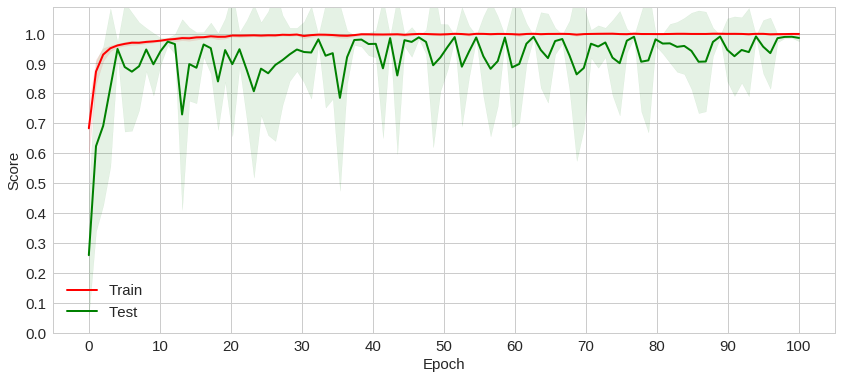

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

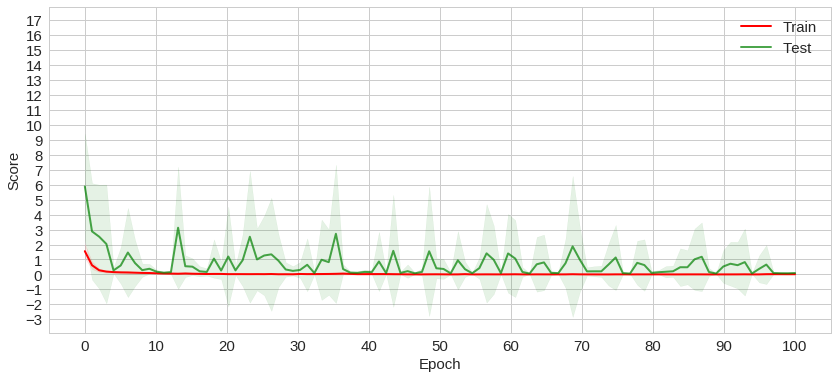

In [26]:
plot_mean_loss(hist)